# NLP From Scratch: Generating Names with a Character-Level RNN Lesson 2: Exercises

### Мы все еще создаем вручную небольшой RNN с несколькими линейными слоями. Большая разница в том, что вместо определения категории после прочтения всех букв названия, мы вводим категорию и выводим по одной букве за раз. Повторяющееся предсказание символов для формирования языка (это также может быть сделано со словами или другими конструкциями более высокого порядка) часто называют “языковой моделью”. Наша задача сегодня - создание/генерация имён на основе разных языков.

## Условие задания

1. Try with a different dataset of category -> line, for example:

Fictional series -> Character name

Part of speech -> Word

Country -> City

2. Use a “start of sentence” token so that sampling can be done without choosing a start letter

3. Get better results with a bigger and/or better shaped network

4. Try the nn.LSTM and nn.GRU layers

5. Combine multiple of these RNNs as a higher level network

### Импортируемые библиотеки

In [ ]:
from io import open
import glob
import os
import unicodedata
import string
import random
import time
import math
from typing import List, Dict, Tuple, Optional, Set
from collections import Counter
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

### Общие функции для репрезентации данных

In [ ]:
# ===============================
# DATA PREPARATION
# ===============================

all_letters: str = string.ascii_letters + " .,;'-"
n_letters: int = len(all_letters) + 1  # Число букв с учётом EOS маркера
SOS_token: int = n_letters  # Токен начала предложения (SOS-токен)
n_letters_with_sos: int = n_letters + 1  # Общее число букв, включая SOS-токен


def findFiles(path: str) -> List[str]:
    """Находит все файлы, подходящие под заданный путевой паттерн."""
    return glob.glob(path)


def unicodeToAscii(s: str) -> str:
    """Перевод Unicode строки в строку ASCII."""
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


def readLines(filename: str) -> List[str]:
    """Чтение файла и его разбиение на отдельные линии."""
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

### Подключение Гугл-диска для получения датасета

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Загрузка тренировочного датасета

In [ ]:
# Build the category_lines dictionary
category_lines: Dict[str, List[str]] = {}
all_categories: List[str] = []

for filename in findFiles('/content/drive/MyDrive/data/names/*.txt'):
    category: str = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines: List[str] = readLines(filename)
    category_lines[category] = lines

n_categories: int = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(f"Example conversion: {unicodeToAscii('ONéàl')}")

# categories: 18 ['Korean', 'English', 'German', 'Greek', 'Irish', 'Japanese', 'Czech', 'Italian', 'French', 'Dutch', 'Portuguese', 'Scottish', 'Arabic', 'Spanish', 'Vietnamese', 'Polish', 'Chinese', 'Russian']
Example conversion: ONeal


## Модели-Архитектуры

In [ ]:
# ===============================
# MODEL ARCHITECTURES
# ===============================

#===========================================================================================
# Модель 1: Базовая RNN модель с 3-мя линейными слоями, dropout и softmax функцией активации
#===========================================================================================

class RNN(nn.Module):
    """Базовая RNN для генерации имен для определённой категории."""

    def __init__(self, input_size: int, hidden_size: int, output_size: int) -> None:
        super(RNN, self).__init__()
        self.hidden_size: int = hidden_size

        self.i2h: nn.Linear = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o: nn.Linear = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o: nn.Linear = nn.Linear(hidden_size + output_size, output_size)
        self.dropout: nn.Dropout = nn.Dropout(0.1)
        self.softmax: nn.LogSoftmax = nn.LogSoftmax(dim=1)

    def forward(
        self,
        category: torch.Tensor,
        input: torch.Tensor,
        hidden: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Функция прямого обхода базовой RNN-модели"""
        input_combined: torch.Tensor = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output: torch.Tensor = self.i2o(input_combined)
        output_combined: torch.Tensor = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self) -> torch.Tensor:
        """Инициализация скрытых слоёв нулями."""
        return torch.zeros(1, self.hidden_size)

#==================================================================================================================
# Модель 2: Базовая LSTM модель с эмбеддингом, nn.LSTM, 2-мя линейными слоями, dropout и softmax функцией активации
#==================================================================================================================

class LSTM_Generator(nn.Module):
    """LSTM-based name generator."""

    def __init__(self, input_size: int, hidden_size: int, output_size: int, dropout: float = 0.2) -> None:
        super(LSTM_Generator, self).__init__()
        self.hidden_size: int = hidden_size

        self.embedding: nn.Embedding = nn.Embedding(input_size, hidden_size)
        self.category_embed: nn.Linear = nn.Linear(n_categories, hidden_size)

        self.lstm: nn.LSTM = nn.LSTM(hidden_size * 2, hidden_size, batch_first=False)
        self.dropout: nn.Dropout = nn.Dropout(dropout)
        self.out: nn.Linear = nn.Linear(hidden_size, output_size)
        self.softmax: nn.LogSoftmax = nn.LogSoftmax(dim=1)

    def forward(
        self,
        category: torch.Tensor,
        input: torch.Tensor,
        hidden: Tuple[torch.Tensor, torch.Tensor]
    ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """Функция прямого обхода базовой LSTM-модели"""
        input_idx: torch.Tensor = input.argmax(dim=1)
        embedded: torch.Tensor = self.embedding(input_idx)

        cat_embed: torch.Tensor = self.category_embed(category)
        combined: torch.Tensor = torch.cat((embedded, cat_embed), 1).unsqueeze(0)

        output: torch.Tensor
        output, hidden = self.lstm(combined, hidden)
        output = self.dropout(output.squeeze(0))
        output = self.out(output)
        output = self.softmax(output)

        return output, hidden

    def initHidden(self) -> Tuple[torch.Tensor, torch.Tensor]:
        """Инициализация скрытых слоёв LSTM-модели нулями."""
        return (torch.zeros(1, 1, self.hidden_size),
                torch.zeros(1, 1, self.hidden_size))

#==================================================================================================================
# Модель 3: Базовая GRU модель с nn.GRU, 3-мя линейными слоями, dropout и softmax функцией активации
#==================================================================================================================

class GRU_Generator(nn.Module):
    """GRU-based name generator with proper dimensionality."""

    def __init__(self, input_size: int, hidden_size: int, output_size: int, dropout: float = 0.2) -> None:
        super(GRU_Generator, self).__init__()
        self.hidden_size: int = hidden_size

        # Combine category, input, and hidden into a single representation
        self.i2h: nn.Linear = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o: nn.Linear = nn.Linear(n_categories + input_size + hidden_size, output_size)

        # GRU takes concatenated hidden and output as input
        self.gru: nn.GRU = nn.GRU(hidden_size + output_size, hidden_size, batch_first=False)

        # Final output layer
        self.o2o: nn.Linear = nn.Linear(hidden_size, output_size)
        self.dropout: nn.Dropout = nn.Dropout(dropout)
        self.softmax: nn.LogSoftmax = nn.LogSoftmax(dim=1)

    def forward(
        self,
        category: torch.Tensor,
        input: torch.Tensor,
        hidden: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Функция прямого обхода базовой GRU-модели"""
        input_combined: torch.Tensor = torch.cat((category, input, hidden), 1)

        # Get preliminary hidden and output
        hidden_new: torch.Tensor = self.i2h(input_combined)
        output_prelim: torch.Tensor = self.i2o(input_combined)

        # Combine for GRU processing
        gru_input: torch.Tensor = torch.cat((hidden_new, output_prelim), 1)

        # Process through GRU
        # Shape: (seq_len=1, batch=1, features)
        gru_out: torch.Tensor
        hidden_out: torch.Tensor
        gru_out, hidden_out = self.gru(gru_input.unsqueeze(0), hidden.unsqueeze(0))

        # Remove extra dimensions
        gru_out = gru_out.squeeze(0)
        hidden_out = hidden_out.squeeze(0)

        # Final output transformation
        output: torch.Tensor = self.o2o(gru_out)
        output = self.dropout(output)
        output = self.softmax(output)

        return output, hidden_out

    def initHidden(self) -> torch.Tensor:
        """Инициализация скрытых слоёв GRU-модели нулями."""
        return torch.zeros(1, self.hidden_size)

#==================================================================================================================
# Модель 4: Deep RNN модель с nn.RNN, 4-мя линейными слоями, dropout и softmax функцией активации
#==================================================================================================================

class DeepRNN_Generator(nn.Module):
    """Deep RNN with multiple layers for name generation."""

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        output_size: int,
        n_layers: int = 2,
        dropout: float = 0.3
    ) -> None:
        super(DeepRNN_Generator, self).__init__()
        self.hidden_size: int = hidden_size
        self.n_layers: int = n_layers

        self.category_embed: nn.Linear = nn.Linear(n_categories, hidden_size)
        self.input_embed: nn.Linear = nn.Linear(input_size, hidden_size)

        self.rnn: nn.RNN = nn.RNN(
            hidden_size * 2,
            hidden_size,
            num_layers=n_layers,
            dropout=dropout if n_layers > 1 else 0
        )

        self.hidden2hidden: nn.Linear = nn.Linear(hidden_size, hidden_size // 2)
        self.hidden2out: nn.Linear = nn.Linear(hidden_size // 2, output_size)
        self.dropout: nn.Dropout = nn.Dropout(dropout)
        self.softmax: nn.LogSoftmax = nn.LogSoftmax(dim=1)

    def forward(
        self,
        category: torch.Tensor,
        input: torch.Tensor,
        hidden: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Функция прямого обхода Deep RNN-модели"""
        cat_embed: torch.Tensor = self.category_embed(category)
        input_embed: torch.Tensor = self.input_embed(input)
        combined: torch.Tensor = torch.cat((cat_embed, input_embed), 1)

        rnn_out: torch.Tensor
        rnn_out, hidden = self.rnn(combined.unsqueeze(0), hidden)

        output: torch.Tensor = self.dropout(rnn_out.squeeze(0))
        output = torch.relu(self.hidden2hidden(output))
        output = self.hidden2out(output)
        output = self.softmax(output)

        return output, hidden

    def initHidden(self) -> torch.Tensor:
        """Инициализация скрытых слоёв Deep RNN-модели нулями."""
        return torch.zeros(self.n_layers, 1, self.hidden_size)


#======================================================================================================================================================================================================
# Модель 5: Residual LSTM модель с nn.ModuleList для многослойности, 2-мя линейными слоями, dropout, layer norm и выходной nn.Sequential слой, состоящий из 2-х линейных слоёв, ReLU, Dropout и SoftMax
#======================================================================================================================================================================================================

class ResidualLSTM(nn.Module):
    """LSTM с residual connections для лучшей градиентной пропагации."""

    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 output_size: int,
                 n_layers: int = 2,
                 dropout: float = 0.3
    ) -> None:
        super(ResidualLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        # Эмбеддинги
        self.category_embed = nn.Linear(n_categories, hidden_size)
        self.input_embed = nn.Linear(input_size, hidden_size)

        # Несколько LSTM слоев
        self.lstm_layers = nn.ModuleList([
            nn.LSTM(hidden_size * 2 if i == 0 else hidden_size,
                   hidden_size, batch_first=False)
            for i in range(n_layers)
        ])

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_size)

        # Выходной слой
        self.output_layers = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, output_size),
            nn.LogSoftmax(dim=1)
        )

    def forward(self,
                category: torch.Tensor,
                input: torch.Tensor,
                hidden: List[Tuple[torch.Tensor, torch.Tensor]]
    ) -> Tuple[torch.Tensor, List[Tuple[torch.Tensor, torch.Tensor]]]:
        """Функция прямого обхода ResidualLSTM-модели"""
        if input.dim() == 2:
            input_idx = input.argmax(dim=1)
            input_embed = self.input_embed(input)
        else:
            input_embed = self.input_embed(input)

        cat_embed = self.category_embed(category)
        combined = torch.cat((input_embed, cat_embed), 1).unsqueeze(0)

        new_hidden = []
        x = combined

        # Проходим через LSTM слои с residual connections
        for i, lstm_layer in enumerate(self.lstm_layers):
            lstm_out, h = lstm_layer(x, hidden[i])

            # Residual connection (кроме первого слоя)
            if i > 0:
                lstm_out = lstm_out + x

            # Layer normalization
            lstm_out = self.layer_norm(lstm_out.squeeze(0)).unsqueeze(0)

            # Dropout
            lstm_out = self.dropout(lstm_out)

            x = lstm_out
            new_hidden.append(h)

        # Финальный выход
        output = self.output_layers(x.squeeze(0))

        return output, new_hidden

    def initHidden(self) -> List[Tuple[torch.Tensor, torch.Tensor]]:
        """Инициализация скрытых слоёв ResidualLSTM-модели нулями."""
        return [(torch.zeros(1, 1, self.hidden_size),
                 torch.zeros(1, 1, self.hidden_size))
                for _ in range(self.n_layers)]

#======================================================================================================================================================================================================
# Модель 6: AttentionGRU модель с 3-мя линейными слоями, nn.GRU и выходным nn.Sequential слоем, стостоящим из 2-х линейных слоёв, ReLU, Dropout и LogSoftmax
#=====================================================================================================================================================================================================
class AttentionGRU(nn.Module):
    """GRU с attention механизмом над категорией."""

    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 output_size: int,
                 dropout: float = 0.2
    ) -> None:
        super(AttentionGRU, self).__init__()
        self.hidden_size = hidden_size

        # Эмбеддинги
        self.category_embed = nn.Linear(n_categories, hidden_size)
        self.input_embed = nn.Linear(input_size, hidden_size)

        # Attention
        self.attention = nn.Linear(hidden_size * 2, 1)

        # GRU
        self.gru = nn.GRU(hidden_size * 2, hidden_size, batch_first=False)

        # Выходной слой
        self.out = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, output_size),
            nn.LogSoftmax(dim=1)
        )

    def forward(self,
                category: torch.Tensor,
                input: torch.Tensor,
                hidden: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Функция прямого обхода AttentionGRU-модели"""
        # Эмбеддинги
        cat_embed = self.category_embed(category)
        input_embed = self.input_embed(input)

        # Attention weight
        attention_input = torch.cat((hidden, cat_embed), 1)
        attention_weight = torch.softmax(self.attention(attention_input), dim=1)

        # Применяем attention к категории
        attended_category = cat_embed * attention_weight

        # Объединяем с input
        combined = torch.cat((input_embed, attended_category), 1).unsqueeze(0)

        # GRU
        gru_out, hidden = self.gru(combined, hidden.unsqueeze(0))

        # Выход
        output = self.out(gru_out.squeeze(0))

        return output, hidden.squeeze(0)

    def initHidden(self) -> torch.Tensor:
        """Инициализация скрытых слоёв AttentionGRU-модели нулями."""
        return torch.zeros(1, self.hidden_size)

## Вспомогательные тренировочные функции

In [ ]:
# ===============================
# TRAINING UTILITIES
# ===============================

def randomChoice(l: List[str]) -> str:
    """Random item from a list."""
    return l[random.randint(0, len(l) - 1)]


def randomTrainingPair() -> Tuple[str, str]:
    """Get a random category and random line from that category."""
    category: str = randomChoice(all_categories)
    line: str = randomChoice(category_lines[category])
    return category, line


def categoryTensor(category: str) -> torch.Tensor:
    """One-hot vector for category."""
    li: int = all_categories.index(category)
    tensor: torch.Tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor


def inputTensor(line: str, use_sos: bool = False) -> torch.Tensor:
    """One-hot matrix of letters for input."""
    size: int = n_letters_with_sos if use_sos else n_letters
    tensor: torch.Tensor = torch.zeros(len(line), 1, size)
    for li in range(len(line)):
        letter: str = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor


def targetTensor(line: str) -> torch.LongTensor:
    """LongTensor of second letter to end (EOS) for target."""
    letter_indexes: List[int] = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1)  # EOS
    return torch.LongTensor(letter_indexes)


def randomTrainingExample(use_sos: bool = False) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Make category, input, and target tensors from a random pair."""
    category: str
    line: str
    category, line = randomTrainingPair()
    category_tensor: torch.Tensor = categoryTensor(category)
    input_line_tensor: torch.Tensor = inputTensor(line, use_sos)
    target_line_tensor: torch.Tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

### Основные функции для тренировки модели

In [ ]:
def train_step(
    model: nn.Module,
    category_tensor: torch.Tensor,
    input_line_tensor: torch.Tensor,
    target_line_tensor: torch.Tensor,
    criterion: nn.Module,
    learning_rate: float,
    is_lstm: bool = False
) -> Tuple[torch.Tensor, float]:
    """Train the model on one example."""
    target_line_tensor.unsqueeze_(-1)
    hidden = model.initHidden()

    model.zero_grad()

    loss: torch.Tensor = torch.Tensor([0])

    for i in range(input_line_tensor.size(0)):
        output: torch.Tensor
        output, hidden = model(category_tensor, input_line_tensor[i], hidden)
        l: torch.Tensor = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    # Manual gradient descent - метод градиентного спуска
    for p in model.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)


def timeSince(since: float) -> str:
    """Подсчет пройденного времени относительно временного штампа timestamp."""
    now: float = time.time()
    s: float = now - since
    m: int = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def train_model(
    model: nn.Module,
    model_name: str,
    n_iters: int = 100000,
    learning_rate: float = 0.0005,
    print_every: int = 5000,
    plot_every: int = 500,
    use_sos: bool = False,
    is_lstm: bool = False
) -> List[float]:
    """Train a model and return losses."""
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")

    criterion: nn.NLLLoss = nn.NLLLoss()
    all_losses: List[float] = []
    total_loss: float = 0

    start: float = time.time()

    for iter in range(1, n_iters + 1):
        output: torch.Tensor
        loss: float
        output, loss = train_step(
            model,
            *randomTrainingExample(use_sos),
            criterion,
            learning_rate,
            is_lstm
        )
        total_loss += loss

        if iter % print_every == 0:
            print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

        if iter % plot_every == 0:
            all_losses.append(total_loss / plot_every)
            total_loss = 0

    return all_losses

## Функции семплирования

### Обыкновенное семплирование

In [ ]:
# ===============================
# SAMPLING/GENERATION
# ===============================

max_length: int = 20


def sample(
    model: nn.Module,
    category: str,
    start_letter: Optional[str] = None,
    use_sos: bool = False,
    is_lstm: bool = False
) -> str:
    """Семплирование из некоторой категории на основе стартовой буквы."""
    with torch.no_grad():
        category_tensor: torch.Tensor = categoryTensor(category)

        if start_letter is None or use_sos:
            # Use SOS token
            if use_sos:
                input: torch.Tensor = torch.zeros(1, n_letters_with_sos)
                input[0][SOS_token] = 1
                output_name: str = ""
            else:
                # Pick random starting letter
                start_letter = all_letters[random.randint(0, len(all_letters) - 1)]
                input = inputTensor(start_letter, use_sos)
                output_name = start_letter
        else:
            input = inputTensor(start_letter, use_sos)
            output_name = start_letter

        hidden = model.initHidden()

        for i in range(max_length):
            output: torch.Tensor
            if input.dim() == 3:
                # If input is (seq_len, batch, features), take first element
                input_slice = input[0]
            else:
                # If input is already (batch, features), use as is
                input_slice = input
            output, hidden = model(category_tensor, input_slice, hidden)
            topv: torch.Tensor
            topi: torch.Tensor
            topv, topi = output.topk(1)
            topi_item: int = topi[0][0].item()

            if topi_item == n_letters - 1:
                break
            else:
                letter: str = all_letters[topi_item]
                output_name += letter

            size: int = n_letters_with_sos if use_sos else n_letters
            input = torch.zeros(1, size)
            input[0][topi_item] = 1

        return output_name


def samples(
    model: nn.Module,
    category: str,
    start_letters: str = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ',
    use_sos: bool = False,
    is_lstm: bool = False
) -> None:
    """Получение множественных семплов из одной категории."""
    print(f"\n{category}:")
    for start_letter in start_letters:
        print(f"  {start_letter}: {sample(model, category, start_letter, use_sos, is_lstm)}")

### Семплирование с температурой

In [ ]:
def sample_with_temperature(
    model: nn.Module,
    category: str,
    temperature: float = 1.0,
    start_letter: Optional[str] = None,
    use_sos: bool = False,
    is_lstm: bool = False
) -> str:
    """
    Sample with temperature scaling for controlling randomness.

    Args:
        temperature: Higher values (>1.0) make output more random,
                    lower values (<1.0) make it more deterministic.
                    temperature=1.0 is standard sampling.
    """
    with torch.no_grad():
        category_tensor: torch.Tensor = categoryTensor(category)

        if start_letter is None or use_sos:
            if use_sos:
                input: torch.Tensor = torch.zeros(1, n_letters_with_sos)
                input[0][SOS_token] = 1
                output_name: str = ""
            else:
                start_letter = all_letters[random.randint(0, len(all_letters) - 1)]
                input = inputTensor(start_letter, use_sos)
                output_name = start_letter
        else:
            input = inputTensor(start_letter, use_sos)
            output_name = start_letter

        hidden = model.initHidden()

        for i in range(max_length):
            output: torch.Tensor
            if input.dim() == 3:
                input_slice = input[0]
            else:
                input_slice = input
            output, hidden = model(category_tensor, input_slice, hidden)

            # Apply temperature scaling
            output = output / temperature

            # Convert log probabilities to probabilities
            probs: torch.Tensor = torch.exp(output)
            probs = probs / probs.sum()  # Normalize

            # Sample from the distribution
            topi_item: int = torch.multinomial(probs, 1).item()

            if topi_item == n_letters - 1:
                break
            else:
                letter: str = all_letters[topi_item]
                output_name += letter

            size: int = n_letters_with_sos if use_sos else n_letters
            input = torch.zeros(1, size)
            input[0][topi_item] = 1

        return output_name

### Метод поиска по лучу

In [ ]:
def beam_search(
    model: nn.Module,
    category: str,
    beam_width: int = 5,
    start_letter: Optional[str] = None,
    use_sos: bool = False,
    is_lstm: bool = False
) -> List[Tuple[str, float]]:
    """
    Beam search for finding most probable sequences.

    Returns:
        List of (name, score) tuples sorted by score.
    """
    with torch.no_grad():
        category_tensor: torch.Tensor = categoryTensor(category)

        # Initialize beams: (sequence, score, hidden, input)
        if start_letter is None or use_sos:
            if use_sos:
                initial_input: torch.Tensor = torch.zeros(1, n_letters_with_sos)
                initial_input[0][SOS_token] = 1
                beams: List[Tuple[str, float, any, torch.Tensor]] = [
                    ("", 0.0, model.initHidden(), initial_input)
                ]
            else:
                start_letter = all_letters[random.randint(0, len(all_letters) - 1)]
                initial_input = inputTensor(start_letter, use_sos)
                beams = [(start_letter, 0.0, model.initHidden(), initial_input)]
        else:
            initial_input = inputTensor(start_letter, use_sos)
            beams = [(start_letter, 0.0, model.initHidden(), initial_input)]

        completed: List[Tuple[str, float]] = []

        for step in range(max_length):
            all_candidates: List[Tuple[str, float, any, torch.Tensor]] = []

            for seq, score, hidden, input_tensor in beams:
                output: torch.Tensor
                if input_tensor.dim() == 3:
                    input_slice = input_tensor[0]
                else:
                    input_slice = input_tensor
                output, new_hidden = model(category_tensor, input_slice, hidden)

                # Get top k predictions
                topv: torch.Tensor
                topi: torch.Tensor
                topv, topi = output.topk(min(beam_width, output.size(1)))

                for i in range(topv.size(1)):
                    token_id: int = topi[0][i].item()
                    token_score: float = topv[0][i].item()

                    if token_id == n_letters - 1:  # EOS
                        completed.append((seq, score + token_score))
                    else:
                        letter: str = all_letters[token_id]
                        new_seq: str = seq + letter
                        new_score: float = score + token_score

                        size: int = n_letters_with_sos if use_sos else n_letters
                        new_input: torch.Tensor = torch.zeros(1, size)
                        new_input[0][token_id] = 1

                        all_candidates.append((new_seq, new_score, new_hidden, new_input))

            # Keep top beam_width candidates
            if not all_candidates:
                break

            beams = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]

        # Add remaining beams to completed
        for seq, score, _, _ in beams:
            completed.append((seq, score))

        # Sort by score and return
        return sorted(completed, key=lambda x: x[1], reverse=True)


### Метод семлирования на основе ансамбля моделей

In [ ]:
def ensemble_sample(
    models: List[nn.Module],
    category: str,
    start_letter: Optional[str] = None,
    use_sos: bool = False,
    voting_method: str = 'majority'
) -> str:
    """
    Generate names using ensemble of models.

    Args:
        voting_method: 'majority' for most common output,
                      'average_char' for character-level averaging
    """
    if voting_method == 'majority':
        # Generate multiple samples and vote
        votes: Dict[str, int] = {}
        for model in models:
            name: str = sample(model, category, start_letter, use_sos)
            votes[name] = votes.get(name, 0) + 1

        # Return most voted name
        if votes:
            return max(votes.items(), key=lambda x: x[1])[0]
        return ""

    elif voting_method == 'average_char':
        # Average probabilities at each character position
        with torch.no_grad():
            category_tensor: torch.Tensor = categoryTensor(category)

            if start_letter is None:
                start_letter = all_letters[random.randint(0, len(all_letters) - 1)]

            input: torch.Tensor = inputTensor(start_letter, use_sos)
            output_name: str = start_letter

            # Initialize hidden states for all models
            hiddens: List = [model.initHidden() for model in models]

            for i in range(max_length):
                # Get outputs from all models
                avg_output: torch.Tensor = torch.zeros(1, n_letters)

                for idx, model in enumerate(models):
                    output: torch.Tensor
                    if input.dim() == 3:
                        input_slice = input[0]
                    else:
                        input_slice = input
                    output, hiddens[idx] = model(category_tensor, input_slice, hiddens[idx])
                    avg_output += torch.exp(output)  # Convert from log probs

                avg_output = avg_output / len(models)
                avg_output = torch.log(avg_output)  # Back to log probs

                topv: torch.Tensor
                topi: torch.Tensor
                topv, topi = avg_output.topk(1)
                topi_item: int = topi[0][0].item()

                if topi_item == n_letters - 1:
                    break
                else:
                    letter: str = all_letters[topi_item]
                    output_name += letter

                size: int = n_letters_with_sos if use_sos else n_letters
                input = torch.zeros(1, size)
                input[0][topi_item] = 1

            return output_name

    return ""

## Класс метрик для оценивания качества генерации моделей

In [ ]:
class GenerationMetrics:
    """Класс для вычисления метрик качества генерации имен."""

    def __init__(self, real_names: List[str], generated_names: List[str])
        self.real_names = real_names
        self.generated_names = generated_names

    def uniqueness_score(self) -> float:
        """Доля уникальных сгенерированных имен."""
        if not self.generated_names:
            return 0.0
        unique = len(set(self.generated_names))
        return unique / len(self.generated_names)

    def memorization_score(self) -> float:
        """Доля имен, которые точно скопированы из обучающей выборки."""
        real_set = set(self.real_names)
        memorized = sum(1 for name in self.generated_names if name in real_set)
        return memorized / len(self.generated_names) if self.generated_names else 0.0

    def average_length(self) -> float:
        """Средняя длина сгенерированных имен."""
        if not self.generated_names:
            return 0.0
        return sum(len(name) for name in self.generated_names) / len(self.generated_names)

    def length_distribution_similarity(self) -> float:
        """Насколько распределение длин похоже на реальные данные (KL-дивергенция)."""
        real_lengths = [len(name) for name in self.real_names]
        gen_lengths = [len(name) for name in self.generated_names]

        # Создаем гистограммы
        max_len = max(max(real_lengths, default=0), max(gen_lengths, default=0))
        real_hist = np.histogram(real_lengths, bins=range(1, max_len + 2), density=True)[0]
        gen_hist = np.histogram(gen_lengths, bins=range(1, max_len + 2), density=True)[0]

        # Избегаем деления на ноль
        real_hist = real_hist + 1e-10
        gen_hist = gen_hist + 1e-10

        # KL-дивергенция (меньше = лучше)
        kl_div = np.sum(gen_hist * np.log(gen_hist / real_hist))
        return kl_div

    def character_distribution_similarity(self) -> float:
        """Косинусное сходство распределений символов."""
        def get_char_freq(names):
            all_chars = ''.join(names).lower()
            total = len(all_chars)
            freq = Counter(all_chars)
            return {char: count/total for char, count in freq.items()}

        real_freq = get_char_freq(self.real_names)
        gen_freq = get_char_freq(self.generated_names)

        # Все возможные символы
        all_chars = set(real_freq.keys()) | set(gen_freq.keys())

        # Векторы частот
        real_vec = [real_freq.get(c, 0) for c in sorted(all_chars)]
        gen_vec = [gen_freq.get(c, 0) for c in sorted(all_chars)]

        # Косинусное сходство
        similarity = cosine_similarity([real_vec], [gen_vec])[0][0]
        return similarity

    def bigram_overlap(self) -> float:
        """Доля биграмм в сгенерированных именах, которые встречаются в реальных."""
        def get_bigrams(names):
            bigrams = set()
            for name in names:
                for i in range(len(name) - 1):
                    bigrams.add(name[i:i+2])
            return bigrams

        real_bigrams = get_bigrams(self.real_names)
        gen_bigrams = get_bigrams(self.generated_names)

        if not gen_bigrams:
            return 0.0

        overlap = len(real_bigrams & gen_bigrams)
        return overlap / len(gen_bigrams)

    def trigram_overlap(self) -> float:
        """Доля триграмм в сгенерированных именах, которые встречаются в реальных."""
        def get_trigrams(names):
            trigrams = set()
            for name in names:
                for i in range(len(name) - 2):
                    trigrams.add(name[i:i+3])
            return trigrams

        real_trigrams = get_trigrams(self.real_names)
        gen_trigrams = get_trigrams(self.generated_names)

        if not gen_trigrams:
            return 0.0

        overlap = len(real_trigrams & gen_trigrams)
        return overlap / len(gen_trigrams)

    def levenshtein_distance_to_nearest(self, sample_size: int = 100) -> float:
        """Среднее минимальное расстояние Левенштейна до ближайшего реального имени."""
        def levenshtein(s1, s2):
            if len(s1) < len(s2):
                return levenshtein(s2, s1)
            if len(s2) == 0:
                return len(s1)

            previous_row = range(len(s2) + 1)
            for i, c1 in enumerate(s1):
                current_row = [i + 1]
                for j, c2 in enumerate(s2):
                    insertions = previous_row[j + 1] + 1
                    deletions = current_row[j] + 1
                    substitutions = previous_row[j] + (c1 != c2)
                    current_row.append(min(insertions, deletions, substitutions))
                previous_row = current_row

            return previous_row[-1]

        # Сэмплируем для ускорения
        sampled_gen = np.random.choice(
            self.generated_names,
            min(sample_size, len(self.generated_names)),
            replace=False
        )

        distances = []
        for gen_name in sampled_gen:
            min_dist = min(levenshtein(gen_name, real_name)
                          for real_name in self.real_names[:200])  # Ограничиваем для скорости
            distances.append(min_dist)

        return np.mean(distances)

    def compute_all_metrics(self) -> Dict[str, float]:
        """Вычислить все метрики."""
        return {
            'uniqueness': self.uniqueness_score(),
            'memorization': self.memorization_score(),
            'avg_length': self.average_length(),
            'length_kl_div': self.length_distribution_similarity(),
            'char_similarity': self.character_distribution_similarity(),
            'bigram_overlap': self.bigram_overlap(),
            'trigram_overlap': self.trigram_overlap(),
            'avg_edit_distance': self.levenshtein_distance_to_nearest()
        }

    def print_report(self):
        """Отчёт о метриках."""
        metrics = self.compute_all_metrics()

        print("\n" + "="*60)
        print("МЕТРИКИ КАЧЕСТВА ГЕНЕРАЦИИ")
        print("="*60)
        print(f"Уникальность:              {metrics['uniqueness']:.2%}")
        print(f"Запоминание (меньше=лучше): {metrics['memorization']:.2%}")
        print(f"Средняя длина:             {metrics['avg_length']:.2f}")
        print(f"KL-дивергенция длин:       {metrics['length_kl_div']:.4f}")
        print(f"Сходство символов:         {metrics['char_similarity']:.2%}")
        print(f"Перекрытие биграмм:        {metrics['bigram_overlap']:.2%}")
        print(f"Перекрытие триграмм:       {metrics['trigram_overlap']:.2%}")
        print(f"Ср. расстояние редакции:   {metrics['avg_edit_distance']:.2f}")
        print("="*60)

## Функции для оценки моделей

In [ ]:
def evaluate_model(
    model: nn.Module,
    category: str,
    real_names: List[str],
    n_samples: int = 1000,
    use_sos: bool = False,
    is_lstm: bool = False
) -> Dict[str, float]:
    """
    Оценить модель на конкретной категории.

    Args:
        model: Модель для оценки
        category: Категория (язык)
        real_names: Список реальных имен для этой категории
        n_samples: Количество имен для генерации
        use_sos: Использовать ли SOS токен
        is_lstm: Является ли модель LSTM

    Returns:
        Словарь с метриками
    """

    # Генерируем имена
    generated_names = []
    for _ in range(n_samples):
        name = sample(model, category, start_letter=None, use_sos=use_sos, is_lstm=is_lstm)
        generated_names.append(name)

    # Вычисляем метрики
    metrics_obj = GenerationMetrics(real_names, generated_names)
    return metrics_obj.compute_all_metrics()


def compare_models(
    models: Dict[str, Dict],
    category: str,
    real_names: List[str],
    n_samples: int = 500
) -> None:
    """
    Сравнить несколько моделей на одной категории.

    Args:
        models: Словарь {название: {model, use_sos, is_lstm}}
        category: Категория для тестирования
        real_names: Реальные имена
        n_samples: Количество образцов для генерации
    """

    print(f"\n{'='*80}")
    print(f"СРАВНЕНИЕ МОДЕЛЕЙ НА КАТЕГОРИИ: {category}")
    print(f"{'='*80}\n")

    results = {}

    for model_name, model_data in models.items():
        print(f"Оценка модели: {model_name}...")

        # Генерация
        generated = []
        for _ in range(n_samples):
            name = sample(
                model_data['model'],
                category,
                start_letter=None,
                use_sos=model_data['use_sos'],
                is_lstm=model_data.get('is_lstm', False)
            )
            generated.append(name)

        # Метрики
        metrics_obj = GenerationMetrics(real_names, generated)
        metrics = metrics_obj.compute_all_metrics()
        results[model_name] = metrics

        print(f"  Уникальность: {metrics['uniqueness']:.2%}")
        print(f"  Запоминание: {metrics['memorization']:.2%}")
        print(f"  Перекрытие биграмм: {metrics['bigram_overlap']:.2%}\n")

    # Таблица результатов
    print(f"\n{'='*80}")
    print("ИТОГОВАЯ ТАБЛИЦА МЕТРИК")
    print(f"{'='*80}")
    print(f"{'Модель':<20} {'Уник':<8} {'Запом':<8} {'Биграм':<8} {'Триграм':<8} {'Ред.Расст':<10}")
    print("-"*80)

    for model_name, metrics in results.items():
        print(f"{model_name:<20} "
              f"{metrics['uniqueness']:<8.2%} "
              f"{metrics['memorization']:<8.2%} "
              f"{metrics['bigram_overlap']:<8.2%} "
              f"{metrics['trigram_overlap']:<8.2%} "
              f"{metrics['avg_edit_distance']:<10.2f}")
    print("="*80)


def plot_metrics_comparison(models: Dict[str, Dict[str, float]], save_path: str = None):
    """
    Визуализировать сравнение метрик между моделями.

    Args:
        models: {model_name: {metric_name: value}}
        save_path: Путь для сохранения графика
    """
    metrics_to_plot = ['uniqueness', 'bigram_overlap', 'trigram_overlap', 'char_similarity']
    metric_labels = ['Уникальность', 'Биграммы', 'Триграммы', 'Символы']

    model_names = list(models.keys())
    n_models = len(model_names)
    n_metrics = len(metrics_to_plot)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for idx, (metric, label) in enumerate(zip(metrics_to_plot, metric_labels)):
        values = [models[name][metric] for name in model_names]

        axes[idx].bar(range(n_models), values, color='steelblue', alpha=0.7)
        axes[idx].set_xticks(range(n_models))
        axes[idx].set_xticklabels(model_names, rotation=45, ha='right')
        axes[idx].set_ylabel(label)
        axes[idx].set_title(f'{label} по моделям')
        axes[idx].grid(axis='y', alpha=0.3)

        # Добавляем значения над столбцами
        for i, v in enumerate(values):
            axes[idx].text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()


# ===============================
# ПЕРПЛЕКСИЯ И ВЕРОЯТНОСТНЫЕ МЕТРИКИ
# ===============================

def compute_perplexity(
    model: nn.Module,
    test_data: List[Tuple[str, str]],
    use_sos: bool = False,
    is_lstm: bool = False
) -> float:
    """
    Вычислить перплексию модели на тестовых данных.

    Args:
        model: Модель
        test_data: Список пар (category, name)
        use_sos: Использовать SOS токен
        is_lstm: LSTM модель

    Returns:
        Значение перплексии
    """

    model.eval()
    criterion = nn.NLLLoss(reduction='sum')
    total_loss = 0
    total_chars = 0

    with torch.no_grad():
        for category, line in test_data:
            category_tensor = categoryTensor(category)
            input_line_tensor = inputTensor(line, use_sos)
            target_line_tensor = targetTensor(line)

            hidden = model.initHidden()

            for i in range(input_line_tensor.size(0)):
                output, hidden = model(category_tensor, input_line_tensor[i], hidden)
                loss = criterion(output, target_line_tensor[i].unsqueeze(0))
                total_loss += loss.item()
                total_chars += 1

    avg_loss = total_loss / total_chars
    perplexity = np.exp(avg_loss)

    return perplexity

## Эксперименты

## Эксперимент 1: Обучение моделей без использования SOS-токена

### Модель 1: Использование базовой RNN модели со 128 скрытыми слоями.

In [ ]:
# ===============================
# EXPERIMENTS
# ===============================

results: Dict[str, Dict] = {}

# Experiment 1: Basic RNN
print("\n" + "="*60)
print("EXPERIMENT 1: Basic RNN (Baseline)")
print("="*60)
rnn_basic: RNN = RNN(n_letters, 128, n_letters)
losses_rnn: List[float] = train_model(rnn_basic, "Basic RNN", n_iters=50000, learning_rate=0.0005)
results['Basic RNN'] = {'model': rnn_basic, 'losses': losses_rnn, 'use_sos': False, 'is_lstm': False}


EXPERIMENT 1: Basic RNN (Baseline)

Training Basic RNN
0m 21s (5000 10%) 3.6246
0m 42s (10000 20%) 2.6632
1m 2s (15000 30%) 2.9074
1m 25s (20000 40%) 3.0452
1m 50s (25000 50%) 2.1100
2m 15s (30000 60%) 2.0828
2m 37s (35000 70%) 1.9414
2m 57s (40000 80%) 2.3058
3m 18s (45000 90%) 2.1355
3m 46s (50000 100%) 3.5512


### Модель 2: Использование базовой RNN модели со 256 скрытыми слоями.

In [ ]:
# Experiment 2: Larger RNN
print("\n" + "="*60)
print("EXPERIMENT 2: Larger RNN (256 hidden)")
print("="*60)
rnn_large: RNN = RNN(n_letters, 256, n_letters)
losses_large: List[float] = train_model(rnn_large, "Large RNN", n_iters=50000, learning_rate=0.0005)
results['Large RNN'] = {'model': rnn_large, 'losses': losses_large, 'use_sos': False, 'is_lstm': False}


EXPERIMENT 2: Larger RNN (256 hidden)

Training Large RNN
0m 29s (5000 10%) 2.9163
1m 21s (10000 20%) 3.7989
1m 56s (15000 30%) 3.0565
2m 33s (20000 40%) 2.5730
3m 19s (25000 50%) 2.6492
3m 58s (30000 60%) 3.1886
4m 24s (35000 70%) 2.6810
4m 51s (40000 80%) 2.8026
5m 19s (45000 90%) 2.1107
6m 0s (50000 100%) 2.7638


### Модель 3: Использование базовой GRU модели со 128 скрытыми слоями.

In [ ]:
# Experiment 3: GRU (128 hidden)
print("\n" + "="*60)
print("EXPERIMENT 3: GRU Generator")
print("="*60)
gru: GRU_Generator = GRU_Generator(n_letters, 128, n_letters, dropout=0.2)
losses_gru: List[float] = train_model(gru, "Basic GRU", n_iters=50000, learning_rate=0.0005)
results['Basic GRU'] = {'model': gru, 'losses': losses_gru, 'use_sos': False, 'is_lstm': False}


EXPERIMENT 3: GRU Generator

Training Basic GRU
0m 55s (5000 10%) 3.0979
1m 47s (10000 20%) 2.9193
2m 38s (15000 30%) 3.1879
3m 36s (20000 40%) 3.2010
4m 26s (25000 50%) 3.1598
5m 21s (30000 60%) 2.7276
6m 13s (35000 70%) 2.6206
7m 6s (40000 80%) 2.6059
7m 56s (45000 90%) 2.8476
8m 48s (50000 100%) 2.6885


### Модель 4: Использование глубокой RNN модели со 128 скрытыми слоями.

In [ ]:
# Experiment 4: Deep RNN (128 hidden, 2 layers)
print("\n" + "="*60)
print("EXPERIMENT 4: Deep RNN (2 layers)")
print("="*60)
deep_rnn: DeepRNN_Generator = DeepRNN_Generator(n_letters, 128, n_letters, n_layers=2, dropout=0.3)
losses_deep: List[float] = train_model(deep_rnn, "Deep RNN", n_iters=50000, learning_rate=0.0005)
results['Deep RNN'] = {'model': deep_rnn, 'losses': losses_deep, 'use_sos': False, 'is_lstm': False}


EXPERIMENT 4: Deep RNN (2 layers)

Training Deep RNN
0m 49s (5000 10%) 2.8957
1m 38s (10000 20%) 2.8802
2m 29s (15000 30%) 2.7002
3m 18s (20000 40%) 3.0799
4m 8s (25000 50%) 1.8621
4m 59s (30000 60%) 2.1406
5m 50s (35000 70%) 1.7554
6m 40s (40000 80%) 2.4500
7m 31s (45000 90%) 1.4992
8m 22s (50000 100%) 2.4203


### Модель 5: Использование базовой LSTM модели со 128 скрытыми слоями.

In [ ]:
# Experiment 5: LSTM
print("\n" + "="*60)
print("EXPERIMENT 5: LSTM Generator (128 hidden)")
print("="*60)
lstm_1: LSTM_Generator = LSTM_Generator(n_letters, 128, n_letters, dropout=0.2)
losses_lstm_1: List[float] = train_model(lstm_1, "Basic LSTM", n_iters=50000, learning_rate=0.0005)
results['Basic LSTM'] = {'model': lstm_1, 'losses': losses_lstm_1, 'use_sos': False, 'is_lstm': True}


EXPERIMENT 5: LSTM Generator (128 hidden)

Training Basic LSTM
1m 15s (5000 10%) 2.6002
2m 34s (10000 20%) 2.5992
3m 48s (15000 30%) 2.6565
5m 1s (20000 40%) 2.5533
6m 19s (25000 50%) 2.2985
7m 39s (30000 60%) 2.3974
8m 54s (35000 70%) 2.7197
10m 9s (40000 80%) 2.3163
11m 24s (45000 90%) 2.4492
12m 38s (50000 100%) 2.1774


### Модель 6: Использование глубокой LSTM модели со 256 скрытыми слоями.

In [ ]:
# Experiment 6: Deep LSTM
print("\n" + "="*60)
print("EXPERIMENT 6: Deep LSTM Generator (256 hidden)")
print("="*60)
lstm_2: LSTM_Generator = LSTM_Generator(n_letters, 256, n_letters, dropout=0.2)
losses_lstm_2: List[float] = train_model(lstm_2, "Deep LSTM", n_iters=50000, learning_rate=0.0005)
results['Deep LSTM'] = {'model': lstm_2, 'losses': losses_lstm_2, 'use_sos': False, 'is_lstm': True}


EXPERIMENT 6: Deep LSTM Generator (256 hidden)

Training Deep LSTM
4m 36s (5000 10%) 2.4114
9m 14s (10000 20%) 2.1367
13m 59s (15000 30%) 2.3628
18m 38s (20000 40%) 2.3778
23m 17s (25000 50%) 1.9765
27m 58s (30000 60%) 1.8536
32m 40s (35000 70%) 2.3090
37m 17s (40000 80%) 1.8678
41m 55s (45000 90%) 2.2765
46m 39s (50000 100%) 1.6047


### Модель 7: Использование Residual LSTM модели со 128 скрытыми слоями.

In [ ]:
# Experiment 7: Residual LSTM (128 hidden)
print("\n" + "="*60)
print("EXPERIMENT 7: Residual LSTM Generator (128 hidden)")
print("="*60)
lstm_3: ResidualLSTM = ResidualLSTM(n_letters, 128, n_letters, n_layers=2, dropout=0.3)
losses_lstm_3: List[float] = train_model(lstm_3, "Residual LSTM", n_iters=50000, learning_rate=0.0005)
results['Residual LSTM'] = {'model': lstm_3, 'losses': losses_lstm_3, 'use_sos': False, 'is_lstm': True}


EXPERIMENT 7: Residual LSTM Generator (128 hidden)

Training Residual LSTM
2m 14s (5000 10%) 2.4711
4m 28s (10000 20%) 2.7933
6m 41s (15000 30%) 2.2910
8m 56s (20000 40%) 1.4982
11m 11s (25000 50%) 2.7558
13m 26s (30000 60%) 2.6636
15m 43s (35000 70%) 2.2014
18m 5s (40000 80%) 1.7403
20m 28s (45000 90%) 2.3063
22m 47s (50000 100%) 2.6403


In [ ]:
# Experiment 8: Deep Residual LSTM (256 hidden)
print("\n" + "="*60)
print("EXPERIMENT 8: Deep Residual LSTM Generator (256 hidden)")
print("="*60)
lstm_4: ResidualLSTM = ResidualLSTM(n_letters, 256, n_letters, n_layers=2, dropout=0.3)
losses_lstm_4: List[float] = train_model(lstm_4, "Deep Residual LSTM", n_iters=50000, learning_rate=0.0005)
results['Deep Residual LSTM'] = {'model': lstm_4, 'losses': losses_lstm_4, 'use_sos': False, 'is_lstm': True}


EXPERIMENT 8: Deep Residual LSTM Generator (256 hidden)

Training Deep Residual LSTM
8m 40s (5000 10%) 3.0330
17m 32s (10000 20%) 1.9948
26m 4s (15000 30%) 2.8381
34m 42s (20000 40%) 3.1066
43m 33s (25000 50%) 2.2373
52m 22s (30000 60%) 3.1612
61m 11s (35000 70%) 1.7423
69m 46s (40000 80%) 1.6333
78m 27s (45000 90%) 2.8818
87m 18s (50000 100%) 1.9220


### Модель 9: Использование глубокой GRU модели со 256 скрытыми слоями.

In [ ]:
# Experiment 9: Deep GRU
print("\n" + "="*60)
print("EXPERIMENT 9: Deep GRU Generator (256 hidden)")
print("="*60)
gru_2: GRU_Generator = GRU_Generator(n_letters, 256, n_letters, dropout=0.2)
losses_gru_2: List[float] = train_model(gru_2, "Deep GRU", n_iters=50000, learning_rate=0.0005)
results['Deep GRU'] = {'model': gru_2, 'losses': losses_gru_2, 'use_sos': False, 'is_lstm': False}


EXPERIMENT 9: Deep GRU Generator (256 hidden)

Training Deep GRU
1m 23s (5000 10%) 2.4786
2m 48s (10000 20%) 2.4308
4m 12s (15000 30%) 2.6637
5m 40s (20000 40%) 2.8558
7m 8s (25000 50%) 2.9978
8m 34s (30000 60%) 3.1194
9m 59s (35000 70%) 3.4510
11m 26s (40000 80%) 2.9846
12m 57s (45000 90%) 2.6801
14m 23s (50000 100%) 2.4013


### Модель 10: Использование AttentionGRU модели со 128 скрытыми слоями.

In [ ]:
# Experiment 10: Attention GRU (128 hidden)
print("\n" + "="*60)
print("EXPERIMENT 10: Attention GRU Generator (128 hidden)")
print("="*60)
gru_3: AttentionGRU = AttentionGRU(n_letters, 128, n_letters, dropout=0.2)
losses_gru_3: List[float] = train_model(gru_3, "Attention GRU", n_iters=50000, learning_rate=0.0005)
results['Attention GRU'] = {'model': gru_3, 'losses': losses_gru_3, 'use_sos': False, 'is_lstm': False}

### Модель 11: Использование глубокой AttentionGRU модели со 256 скрытыми слоями.

In [ ]:
# Experiment 11: Deep Attention GRU (256 hidden)
print("\n" + "="*60)
print("EXPERIMENT 11: Deep Attention GRU Generator (256 hidden)")
print("="*60)
gru_4: AttentionGRU = AttentionGRU(n_letters, 256, n_letters, dropout=0.2)
losses_gru_4: List[float] = train_model(gru_4, "Deep Attention GRU", n_iters=50000, learning_rate=0.0005)
results['Deep Attention GRU'] = {'model': gru_4, 'losses': losses_gru_4, 'use_sos': False, 'is_lstm': False}


EXPERIMENT 11: Deep Attention GRU Generator (256 hidden)

Training Deep Attention GRU
1m 55s (5000 10%) 2.4874
3m 52s (10000 20%) 2.8407
5m 46s (15000 30%) 2.5324
7m 37s (20000 40%) 3.0307
9m 30s (25000 50%) 2.3136
11m 23s (30000 60%) 2.5391
13m 16s (35000 70%) 2.8008
15m 10s (40000 80%) 2.7749
17m 2s (45000 90%) 3.2201
18m 56s (50000 100%) 2.7791


### График функции потерь на тренировочном датасете без SOS-токена

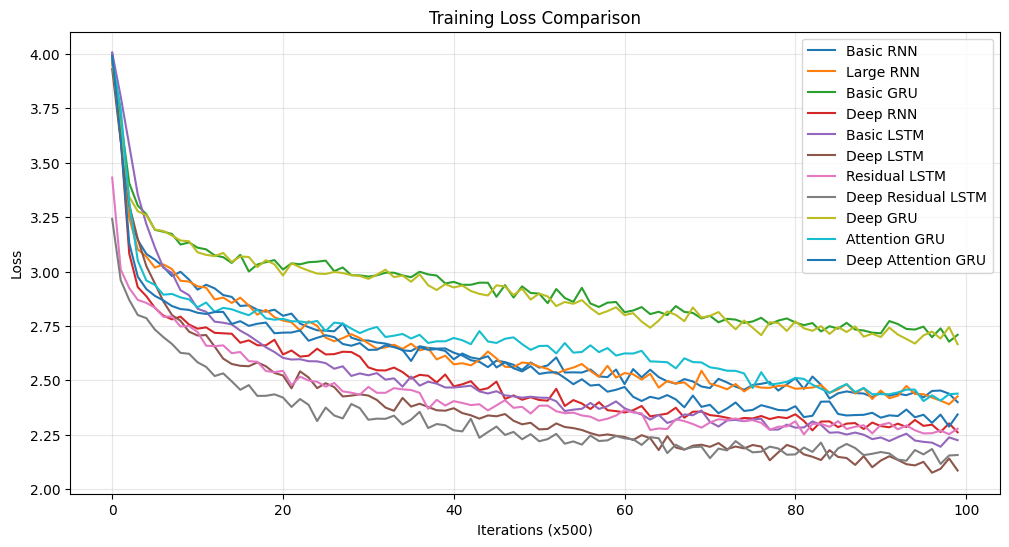

In [ ]:
# Plot all losses
plt.figure(figsize=(12, 6))
for name, data in results.items():
    plt.plot(data['losses'], label=name)
plt.xlabel('Iterations (x500)')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
plt.close()

## Models statistics results per 5000 iters

| Model Name  | 5000 iters |  10000 iters | 15000 iters | 20000 iters | 25000 iters | 30000 iters | 35000 iters | 40000 iters | 45000 iters | 50000 iters |Average value|
|-------|-----|-------| ------|------|------|------|------|------|------|------|------|
| Basic RNN |3.6246|2.6632|2.9074|3.0452|2.1100|2.0828|1.9414|2.3058|2.1355|3.5512|2.6367|
| Large RNN |2.9163|3.7989|3.0565|2.5730|2.6492|3.1886|2.6810|2.8026|2.1107|2.7638|2.8541|
| Basic GRU |3.0979|2.9193|3.1879|3.2010|3.1598|2.7276|2.6206|2.6059|2.8476|2.6885|2.9056|
| Deep RNN |2.8957|2.8802|2.7002|3.0799|1.8621|2.1406|1.7554|2.4500|1.4992|2.4203|2.3684|
| Basic LSTM |2.6002|2.5992|2.6565|2.5533|2.2985|2.3974|2.7197|2.3163|2.4492|2.1774|2.4768|
| Deep LSTM |2.4114|2.1367|2.3628|2.3778|1.9765|1.8536|2.3090|1.8678|2.2765|1.6047|2.1177|
| Residual LSTM |2.4711|2.7933|2.2910|1.4982|2.7558|2.6636|2.2014|1.7403|2.3063|2.6403|2.3361|
| Deep Residual LSTM |3.0330|1.9948|2.8381|3.1066|2.2373|3.1612|1.7423|1.6333|2.8818|1.9220|2.4450|
| Deep GRU |2.4786|2.4308|2.6637|2.8558|2.9978|3.1194|3.4510|2.9846|2.6801|2.4013|2.8063|
| Deep Attention GRU |2.4874|2.8407|2.5324|3.0307|2.3136|2.5391|2.8008|2.7749|3.2201|2.7791|2.7319|

## Model rating by average results

| Model Name  | Average loss | Place |
|-------|-----|-----|
| Deep LSTM |2.1177|1|
| Residual LSTM |2.3361|2|
| Deep RNN |2.3684|3|
| Deep Residual LSTM |2.4450|4|
| Basic LSTM |2.4768|5|
| Basic RNN |2.6367|6|
| Deep Attention GRU |2.7319|7|
| Deep GRU |2.8063|8|
| Large RNN |2.8541|9|
| Basic GRU |2.9056|10|

### ***Results***: best results were shown by Deep LSTM and worst by Basic GRU model

## Эксперимент 2: Обучение моделей с использованием SOS-токена

### Модель 1: Использование базовой RNN модели со 128 скрытыми слоями.

In [ ]:
# ===============================
# EXPERIMENTS
# ===============================

results_sos: Dict[str, Dict] = {}

# Experiment 1: Basic RNN
print("\n" + "="*60)
print("EXPERIMENT 1: Basic RNN (Baseline)")
print("="*60)
rnn_basic_sos: RNN = RNN(n_letters, 128, n_letters)
losses_rnn_sos: List[float] = train_model(rnn_basic_sos, "Basic RNN with SOS", n_iters=50000, learning_rate=0.0005)
results_sos['Basic RNN with SOS'] = {'model': rnn_basic_sos, 'losses': losses_rnn_sos, 'use_sos': True, 'is_lstm': False}


EXPERIMENT 1: Basic RNN (Baseline)

Training Basic RNN with SOS
0m 25s (5000 10%) 2.7824
0m 57s (10000 20%) 2.3055
1m 23s (15000 30%) 2.6715
1m 44s (20000 40%) 2.7353
2m 5s (25000 50%) 2.3261
2m 25s (30000 60%) 1.3448
2m 48s (35000 70%) 2.0199
3m 8s (40000 80%) 2.5434
3m 30s (45000 90%) 2.1462
3m 50s (50000 100%) 2.0246


### Модель 2: Использование базовой RNN модели со 256 скрытыми слоями.

In [ ]:
# Experiment 2: Larger RNN
print("\n" + "="*60)
print("EXPERIMENT 2: Larger RNN (256 hidden)")
print("="*60)
rnn_large_sos: RNN = RNN(n_letters, 256, n_letters)
losses_large_sos: List[float] = train_model(rnn_large_sos, "Large RNN with SOS", n_iters=50000, learning_rate=0.0005)
results_sos['Large RNN with SOS'] = {'model': rnn_large_sos, 'losses': losses_large_sos, 'use_sos': True, 'is_lstm': False}


EXPERIMENT 2: Larger RNN (256 hidden)

Training Large RNN with SOS
0m 26s (5000 10%) 2.7523
0m 52s (10000 20%) 2.8596
1m 19s (15000 30%) 2.7741
1m 45s (20000 40%) 1.9716
2m 11s (25000 50%) 2.9768
2m 37s (30000 60%) 2.7686
3m 3s (35000 70%) 2.3311
3m 29s (40000 80%) 1.9784
3m 55s (45000 90%) 2.7412
4m 20s (50000 100%) 2.1140


### Модель 3: Использование базовой GRU модели со 128 скрытыми слоями.

In [ ]:
# Experiment 3: GRU
print("\n" + "="*60)
print("EXPERIMENT 3: GRU Generator")
print("="*60)
gru_sos: GRU_Generator = GRU_Generator(n_letters, 128, n_letters, dropout=0.2)
losses_gru_sos: List[float] = train_model(gru_sos, "Basic GRU with SOS", n_iters=50000, learning_rate=0.0005)
results_sos['Basic GRU with SOS'] = {'model': gru_sos, 'losses': losses_gru_sos, 'use_sos': True, 'is_lstm': False}


EXPERIMENT 3: GRU Generator

Training GRU with SOS
0m 52s (5000 10%) 3.1269
1m 46s (10000 20%) 3.2523
2m 40s (15000 30%) 2.9748
3m 32s (20000 40%) 2.7853
4m 25s (25000 50%) 2.5823
5m 19s (30000 60%) 3.9877
6m 12s (35000 70%) 2.2955
7m 5s (40000 80%) 2.6912
8m 0s (45000 90%) 3.0397
8m 54s (50000 100%) 2.9391


### Модель 4: Использование глубокой RNN модели со 128 скрытыми слоями.

In [ ]:
# Experiment 4: Deep RNN
print("\n" + "="*60)
print("EXPERIMENT 4: Deep RNN (2 layers)")
print("="*60)
deep_rnn_sos: DeepRNN_Generator = DeepRNN_Generator(n_letters, 128, n_letters, n_layers=2, dropout=0.3)
losses_deep_sos: List[float] = train_model(deep_rnn_sos, "Deep RNN with SOS", n_iters=50000, learning_rate=0.0005)
results_sos['Deep RNN with SOS'] = {'model': deep_rnn_sos, 'losses': losses_deep_sos, 'use_sos': True, 'is_lstm': False}


EXPERIMENT 4: Deep RNN (2 layers)

Training Deep RNN with SOS
0m 52s (5000 10%) 2.6232
1m 44s (10000 20%) 2.9661
2m 35s (15000 30%) 2.4367
3m 27s (20000 40%) 2.5396
4m 18s (25000 50%) 2.2471
5m 9s (30000 60%) 2.1081
6m 1s (35000 70%) 3.1703
6m 52s (40000 80%) 2.4977
7m 43s (45000 90%) 2.9689
8m 34s (50000 100%) 2.6553


### Модель 5: Использование базовой LSTM модели со 128 скрытыми слоями.

In [ ]:
# Experiment 5: LSTM
print("\n" + "="*60)
print("EXPERIMENT 5: LSTM Generator (128 hidden)")
print("="*60)
lstm_1_sos: LSTM_Generator = LSTM_Generator(n_letters, 128, n_letters, dropout=0.2)
losses_lstm_1_sos: List[float] = train_model(lstm_1_sos, "Basic LSTM with SOS", n_iters=50000, learning_rate=0.0005)
results_sos['Basic LSTM with SOS'] = {'model': lstm_1_sos, 'losses': losses_lstm_1_sos, 'use_sos': True, 'is_lstm': True}


EXPERIMENT 5: LSTM Generator (128 hidden)

Training LSTM_1 with SOS
1m 13s (5000 10%) 3.2505
2m 28s (10000 20%) 2.6820
3m 48s (15000 30%) 2.4306
5m 4s (20000 40%) 2.2912
6m 20s (25000 50%) 1.9658
7m 37s (30000 60%) 2.0793
8m 51s (35000 70%) 1.9961
10m 6s (40000 80%) 2.2952
11m 22s (45000 90%) 2.5684
12m 38s (50000 100%) 2.0961


### Модель 6: Использование глубокой LSTM модели со 256 скрытыми слоями.

In [ ]:
# Experiment 6: Deep LSTM
print("\n" + "="*60)
print("EXPERIMENT 6: LSTM Generator (256 hidden)")
print("="*60)
lstm_2_sos: LSTM_Generator = LSTM_Generator(n_letters, 256, n_letters, dropout=0.2)
losses_lstm_2_sos: List[float] = train_model(lstm_2_sos, "Deep LSTM with SOS", n_iters=50000, learning_rate=0.0005)
results_sos['Deep LSTM with SOS'] = {'model': lstm_2_sos, 'losses': losses_lstm_2_sos, 'use_sos': True, 'is_lstm': True}


EXPERIMENT 6: LSTM Generator (256 hidden)

Training Deep LSTM with SOS
3m 46s (5000 10%) 2.3989
7m 37s (10000 20%) 2.4930
11m 24s (15000 30%) 3.1133
15m 15s (20000 40%) 2.3507
19m 1s (25000 50%) 3.1681
22m 50s (30000 60%) 1.2931
26m 51s (35000 70%) 2.3513
30m 55s (40000 80%) 2.7126
35m 3s (45000 90%) 2.3822
38m 59s (50000 100%) 1.8436


### Модель 7: Использование Residual LSTM модели со 128 скрытыми слоями.

In [ ]:
# Experiment 7: Residual LSTM (128 hidden)
print("\n" + "="*60)
print("EXPERIMENT 7: Residual LSTM Generator (128 hidden)")
print("="*60)
lstm_3_sos: ResidualLSTM = ResidualLSTM(n_letters, 128, n_letters, n_layers=2, dropout=0.3)
losses_lstm_3_sos: List[float] = train_model(lstm_3_sos, "Residual LSTM with SOS", n_iters=50000, learning_rate=0.0005)
results_sos['Residual LSTM with SOS'] = {'model': lstm_3_sos, 'losses': losses_lstm_3_sos, 'use_sos': True, 'is_lstm': True}


EXPERIMENT 7: Residual LSTM Generator (128 hidden)

Training Residual LSTM with SOS
2m 28s (5000 10%) 2.6547
4m 52s (10000 20%) 2.5869
7m 17s (15000 30%) 2.1496
9m 46s (20000 40%) 1.8084
12m 20s (25000 50%) 2.7435
14m 47s (30000 60%) 2.4660
17m 10s (35000 70%) 1.1328
19m 35s (40000 80%) 3.8836
22m 10s (45000 90%) 2.1276
25m 19s (50000 100%) 2.3796


### Модель 8: Использование глубокой Residual LSTM модели со 256 скрытыми слоями.

In [53]:
# Experiment 8: Deep Residual LSTM (256 hidden)
print("\n" + "="*60)
print("EXPERIMENT 8: Deep Residual LSTM Generator (256 hidden)")
print("="*60)
lstm_4_sos: ResidualLSTM = ResidualLSTM(n_letters, 256, n_letters, n_layers=2, dropout=0.3)
losses_lstm_4_sos: List[float] = train_model(lstm_4_sos, "Deep Residual LSTM with SOS", n_iters=50000, learning_rate=0.0005)
results_sos['Deep Residual LSTM with SOS'] = {'model': lstm_4_sos, 'losses': losses_lstm_4_sos, 'use_sos': True, 'is_lstm': True}


EXPERIMENT 8: Deep Residual LSTM Generator (256 hidden)

Training Deep Residual LSTM with SOS
6m 54s (5000 10%) 2.5070
13m 32s (10000 20%) 2.7037
20m 21s (15000 30%) 2.2283
26m 48s (20000 40%) 2.3145
33m 24s (25000 50%) 2.9361
39m 51s (30000 60%) 2.1875
46m 31s (35000 70%) 2.3954
52m 56s (40000 80%) 2.4470
59m 25s (45000 90%) 1.5651
66m 1s (50000 100%) 2.0725


### Модель 9: Использование глубокой GRU модели со 256 скрытыми слоями.

In [54]:
# Experiment 9: Deep GRU
print("\n" + "="*60)
print("EXPERIMENT 9: Deep GRU Generator (256 hidden)")
print("="*60)
gru_2_sos: GRU_Generator = GRU_Generator(n_letters, 256, n_letters, dropout=0.2)
losses_gru_2_sos: List[float] = train_model(gru_2_sos, "Deep GRU with SOS", n_iters=50000, learning_rate=0.0005)
results_sos['Deep GRU with SOS'] = {'model': gru_2_sos, 'losses': losses_gru_2_sos, 'use_sos': True, 'is_lstm': False}


EXPERIMENT 9: Deep GRU Generator (256 hidden)

Training Deep GRU with SOS
1m 20s (5000 10%) 2.7413
2m 42s (10000 20%) 3.4053
4m 4s (15000 30%) 3.2002
5m 24s (20000 40%) 2.5848
6m 43s (25000 50%) 2.8411
8m 3s (30000 60%) 3.0388
9m 24s (35000 70%) 3.2497
10m 44s (40000 80%) 2.0578
12m 4s (45000 90%) 3.2615
13m 24s (50000 100%) 2.0059


### Модель 10: Использование AttentionGRU модели со 128 скрытыми слоями.

In [55]:
# Experiment 10: Attention GRU (128 hidden)
print("\n" + "="*60)
print("EXPERIMENT 10: Attention GRU Generator (128 hidden)")
print("="*60)
gru_3_sos: AttentionGRU = AttentionGRU(n_letters, 128, n_letters, dropout=0.2)
losses_gru_3_sos: List[float] = train_model(gru_3_sos, "Attention GRU with SOS", n_iters=50000, learning_rate=0.0005)
results_sos['Attention GRU with SOS'] = {'model': gru_3_sos, 'losses': losses_gru_3_sos, 'use_sos': True, 'is_lstm': False}


EXPERIMENT 10: Attention GRU Generator (128 hidden)

Training Attention GRU with SOS
1m 4s (5000 10%) 2.4436
2m 8s (10000 20%) 2.6863
3m 11s (15000 30%) 2.6362
4m 14s (20000 40%) 2.6389
5m 20s (25000 50%) 2.8433
6m 25s (30000 60%) 2.8098
7m 29s (35000 70%) 2.4349
8m 34s (40000 80%) 2.0022
9m 37s (45000 90%) 2.1953
10m 41s (50000 100%) 2.9092


### Модель 11: Использование глубокой AttentionGRU модели со 256 скрытыми слоями.

In [56]:
# Experiment 11: Deep Attention GRU (256 hidden)
print("\n" + "="*60)
print("EXPERIMENT 11: Deep Attention GRU Generator (256 hidden)")
print("="*60)
gru_4_sos: AttentionGRU = AttentionGRU(n_letters, 256, n_letters, dropout=0.2)
losses_gru_4_sos: List[float] = train_model(gru_4_sos, "Deep Attention GRU with SOS", n_iters=50000, learning_rate=0.0005)
results_sos['Deep Attention GRU with SOS'] = {'model': gru_4_sos, 'losses': losses_gru_4_sos, 'use_sos': True, 'is_lstm': False}


EXPERIMENT 11: Deep Attention GRU Generator (256 hidden)

Training Deep Attention GRU with SOS
1m 43s (5000 10%) 2.5983
3m 25s (10000 20%) 2.1516
5m 8s (15000 30%) 2.2255
6m 51s (20000 40%) 2.8140
8m 35s (25000 50%) 2.6588
10m 18s (30000 60%) 2.1575
11m 59s (35000 70%) 2.9373
13m 42s (40000 80%) 2.2188
15m 25s (45000 90%) 1.7673
17m 9s (50000 100%) 2.0163


### График функции потерь на тренировочном датасете с SOS-токеном

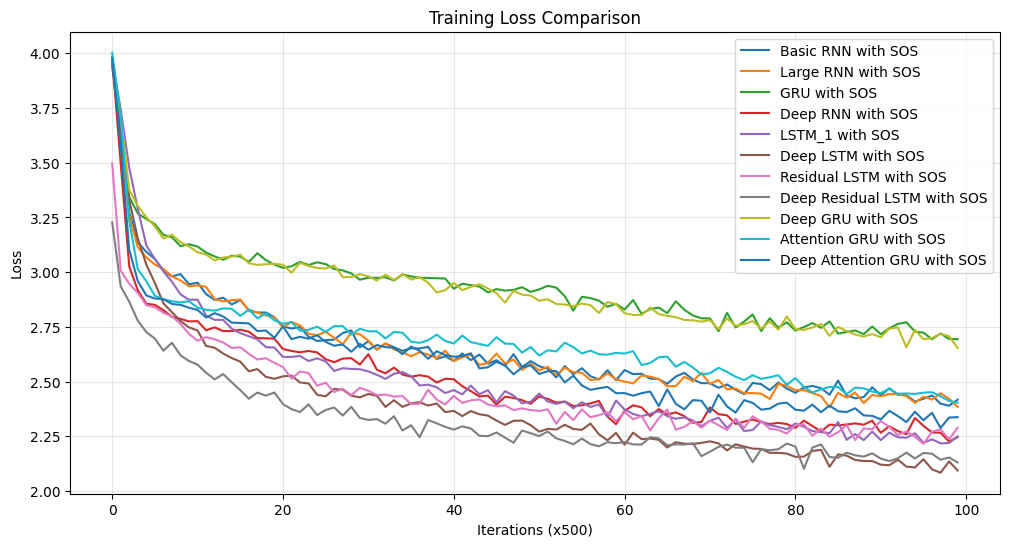

In [57]:
# Plot all losses
plt.figure(figsize=(12, 6))
for name, data in results_sos.items():
    plt.plot(data['losses'], label=name)
plt.xlabel('Iterations (x500)')
plt.ylabel('Loss')
plt.title('Training Loss Comparison With SOS token')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
plt.close()

## Models statistics results per 5000 iters

| Model Name  | 5000 iters |  10000 iters | 15000 iters | 20000 iters | 25000 iters | 30000 iters | 35000 iters | 40000 iters | 45000 iters | 50000 iters |Average value|
|-------|-----|-------| ------|------|------|------|------|------|------|------|------|
| Basic RNN |2.7824|2.3055|2.6715|2.7353|2.3261|1.3448|2.0199|2.5434|2.1462|2.0246|2.2899|
| Large RNN |2.7523|2.8596|2.7741|1.9716|2.9768|2.7686|2.3311|1.9784|2.7412|2.1140|2.5268|
| Basic GRU |3.1269|3.2523|2.9748|2.7853|2.5823|3.9877|2.2955|2.6912|3.0397|2.9391|2.9675|
| Deep RNN |2.6232|2.9661|2.4367|2.5396|2.2471|2.1081|3.1703|2.4977|2.9689|2.6553|2.6183|
| Basic LSTM |3.2505|2.6820|2.4306|2.2912|1.9658|2.0793|1.9961|2.2952|2.5684|2.0961|2.3655|
| Deep LSTM |2.3989|2.4930|3.1133|2.3507|3.1681|1.2931|2.3513|2.7126|2.3822|1.8436|2.4107|
| Residual LSTM |2.6547|2.5869|2.1496|1.8084|2.7435|2.4660|1.1328|3.8836|2.1276|2.3796|2.3933|
| Deep Residual LSTM |2.5070|2.7037|2.2283|2.3145|2.9361|2.1875|2.3954|2.4470|1.5651|2.0725|2.3357|
| Deep GRU |2.7413|3.4053|3.2002|2.5848|2.8411|3.0388|3.2497|2.0578|3.2615|2.0059|2.8386|
| Basic Attention GRU |2.4436|2.6863|2.6362|2.6389|2.8433|2.8098|2.4349|2.0022|2.1953|2.9092|2.5600|
| Deep Attention GRU |2.5983|2.1516|2.2255|2.8140|2.6588|2.1575|2.9373|2.2188|1.7673|2.0163|2.3541|

## Model rating by average results

| Model Name  | Average loss | Place |
|-------|-----|-----|
| Basic RNN |2.2899|1|
| Deep Residual LSTM |2.3357|2|
| Deep Attention GRU |2.3541|3|
| Basic LSTM |2.3655|4|
| Residual LSTM |2.3933|5|
| Deep LSTM |2.4107|6|
| Large RNN |2.5268|7|
| Basic Attention GRU |2.5600|8|
| Deep RNN |2.6183|9|
| Basic GRU |2.9675|10|

### ***Results***: best average results were shown by Basic RNN and worst by Basic GRU model

## Эксперимент 3: Оценка моделей по категориям

In [58]:
# categories: 18 ['Korean', 'English', 'German', 'Greek', 'Irish', 'Japanese', 'Czech', 'Italian', 'French', 'Dutch', 'Portuguese', 'Scottish', 'Arabic', 'Spanish', 'Vietnamese', 'Polish', 'Chinese', 'Russian']
# Example conversion: ONeal
print("\n" + "="*80)
print("КОМПЛЕКСНАЯ ОЦЕНКА КАЧЕСТВА МОДЕЛЕЙ")
print("="*80)

print("\n1. Оценка по категориям:")

test_categories_eval = ['Russian', 'German', 'Spanish', 'Chinese', 'English', 'Japanese', 'Arabic']
n_samples_per_model = 500

all_model_metrics = {}

for model_name, model_data in results.items():
    print(f"\n{'='*60}")
    print(f"Модель: {model_name}")
    print(f"{'='*60}")

    category_metrics = {}

    for category in test_categories_eval:
        real_names = category_lines[category]

        # Генерация имен
        generated_names = []
        for _ in range(n_samples_per_model):
            name = sample(
                model_data['model'],
                category,
                start_letter=None,
                use_sos=model_data['use_sos'],
                is_lstm=model_data.get('is_lstm', False)
            )
            generated_names.append(name)

        # Вычисление метрик
        metrics_obj = GenerationMetrics(real_names, generated_names)
        metrics = metrics_obj.compute_all_metrics()
        category_metrics[category] = metrics

        print(f"\n{category}:")
        print(f"  Уникальность:          {metrics['uniqueness']:.2%}")
        print(f"  Запоминание:           {metrics['memorization']:.2%}")
        print(f"  Средняя длина:         {metrics['avg_length']:.2f}")
        print(f"  Перекрытие биграмм:    {metrics['bigram_overlap']:.2%}")
        print(f"  Перекрытие триграмм:   {metrics['trigram_overlap']:.2%}")
        print(f"  Сходство символов:     {metrics['char_similarity']:.2%}")
        print(f"  Расстояние редакции:   {metrics['avg_edit_distance']:.2f}")

    all_model_metrics[model_name] = category_metrics


КОМПЛЕКСНАЯ ОЦЕНКА КАЧЕСТВА МОДЕЛЕЙ

1. Оценка по категориям:

Модель: Basic RNN

Russian:
  Уникальность:          11.60%
  Запоминание:           0.00%
  Средняя длина:         7.34
  Перекрытие биграмм:    77.94%
  Перекрытие триграмм:   61.84%
  Сходство символов:     69.94%
  Расстояние редакции:   4.31

German:
  Уникальность:          11.60%
  Запоминание:           0.00%
  Средняя длина:         4.99
  Перекрытие биграмм:    71.64%
  Перекрытие триграмм:   52.86%
  Сходство символов:     82.82%
  Расстояние редакции:   2.07

Spanish:
  Уникальность:          11.60%
  Запоминание:           0.00%
  Средняя длина:         4.17
  Перекрытие биграмм:    63.33%
  Перекрытие триграмм:   40.98%
  Сходство символов:     76.03%
  Расстояние редакции:   2.01

Chinese:
  Уникальность:          11.60%
  Запоминание:           17.20%
  Средняя длина:         3.00
  Перекрытие биграмм:    42.62%
  Перекрытие триграмм:   32.14%
  Сходство символов:     75.78%
  Расстояние редакции:   0.80

E

### ***Results***:
| Model | Parameter | Best Language | Worst language |
|--|--|--|--|
|Basic RNN|Remember|Chinese (17.2%)||
|Basic RNN|Average length|Chinese(3.0)|Russian(7.34)|
|Basic RNN|Bigrams|English(81.25%)|Chinese(42.62%)|
|Basic RNN|Trigrams|English(69.70%)|Arabic(24.59%)|
|Basic RNN|Char similarity|Russian(69.94%)|Arabic(82.64%)|
|Basic RNN|Red.length|Russian(4.31)|Chinese(0.8)|

## Эксперимент 4: Результаты метрик по каждой из моделей

In [59]:
print("\n" + "="*80)
print("2. СРАВНИТЕЛЬНАЯ ТАБЛИЦА (усреднение по категориям)")
print("="*80)

comparison_metrics = ['uniqueness', 'memorization', 'bigram_overlap', 'trigram_overlap', 'char_similarity']
metric_names = ['Уникальность', 'Запоминание', 'Биграммы', 'Триграммы', 'Символы']

print(f"\n{'Модель':<20}", end='')
for metric_name in metric_names:
    print(f"{metric_name:<15}", end='')
print()
print("-"*100)

for model_name, category_data in all_model_metrics.items():
    print(f"{model_name:<20}", end='')

    for metric in comparison_metrics:
        # Усредняем по всем категориям
        avg_value = np.mean([cat_metrics[metric] for cat_metrics in category_data.values()])
        print(f"{avg_value:<15.3f}", end='')
    print()

print("="*100)


2. СРАВНИТЕЛЬНАЯ ТАБЛИЦА (усреднение по категориям)

Модель              Уникальность   Запоминание    Биграммы       Триграммы      Символы        
----------------------------------------------------------------------------------------------------
Basic RNN           0.116          0.025          0.647          0.470          0.783          
Large RNN           0.116          0.030          0.653          0.461          0.782          
Basic GRU           0.116          0.030          0.629          0.421          0.740          
Deep RNN            0.116          0.047          0.663          0.481          0.757          
Basic LSTM          0.116          0.034          0.683          0.500          0.786          
Deep LSTM           0.116          0.032          0.719          0.519          0.832          
Residual LSTM       0.116          0.041          0.675          0.466          0.745          
Deep Residual LSTM  0.116          0.043          0.695          0.526       

### ***Results***: best remembering model: Deep RNN, best bigramm model: Deep LSTM, best trigramm model: Deep LSTM, best model by char simmilarity: Attention GRU.

## Эксперимент 5: Получение лучшей модели по каждой рассчитанной метрике


3. ЛУЧШИЕ МОДЕЛИ ПО КАЖДОЙ МЕТРИКЕ

СРАВНЕНИЕ МОДЕЛЕЙ НА КАТЕГОРИИ: Russian

Оценка модели: Basic RNN...
  Уникальность: 11.60%
  Запоминание: 0.00%
  Перекрытие биграмм: 77.94%

Оценка модели: Large RNN...
  Уникальность: 11.60%
  Запоминание: 0.00%
  Перекрытие биграмм: 78.57%

Оценка модели: Basic GRU...
  Уникальность: 11.60%
  Запоминание: 0.00%
  Перекрытие биграмм: 72.58%

Оценка модели: Deep RNN...
  Уникальность: 11.60%
  Запоминание: 0.00%
  Перекрытие биграмм: 81.43%

Оценка модели: Basic LSTM...
  Уникальность: 11.60%
  Запоминание: 0.00%
  Перекрытие биграмм: 81.08%

Оценка модели: Deep LSTM...
  Уникальность: 11.60%
  Запоминание: 0.00%
  Перекрытие биграмм: 82.93%

Оценка модели: Residual LSTM...
  Уникальность: 11.60%
  Запоминание: 0.00%
  Перекрытие биграмм: 81.82%

Оценка модели: Deep Residual LSTM...
  Уникальность: 11.60%
  Запоминание: 2.80%
  Перекрытие биграмм: 77.27%

Оценка модели: Deep GRU...
  Уникальность: 11.60%
  Запоминание: 0.00%
  Перекрытие биграмм: 

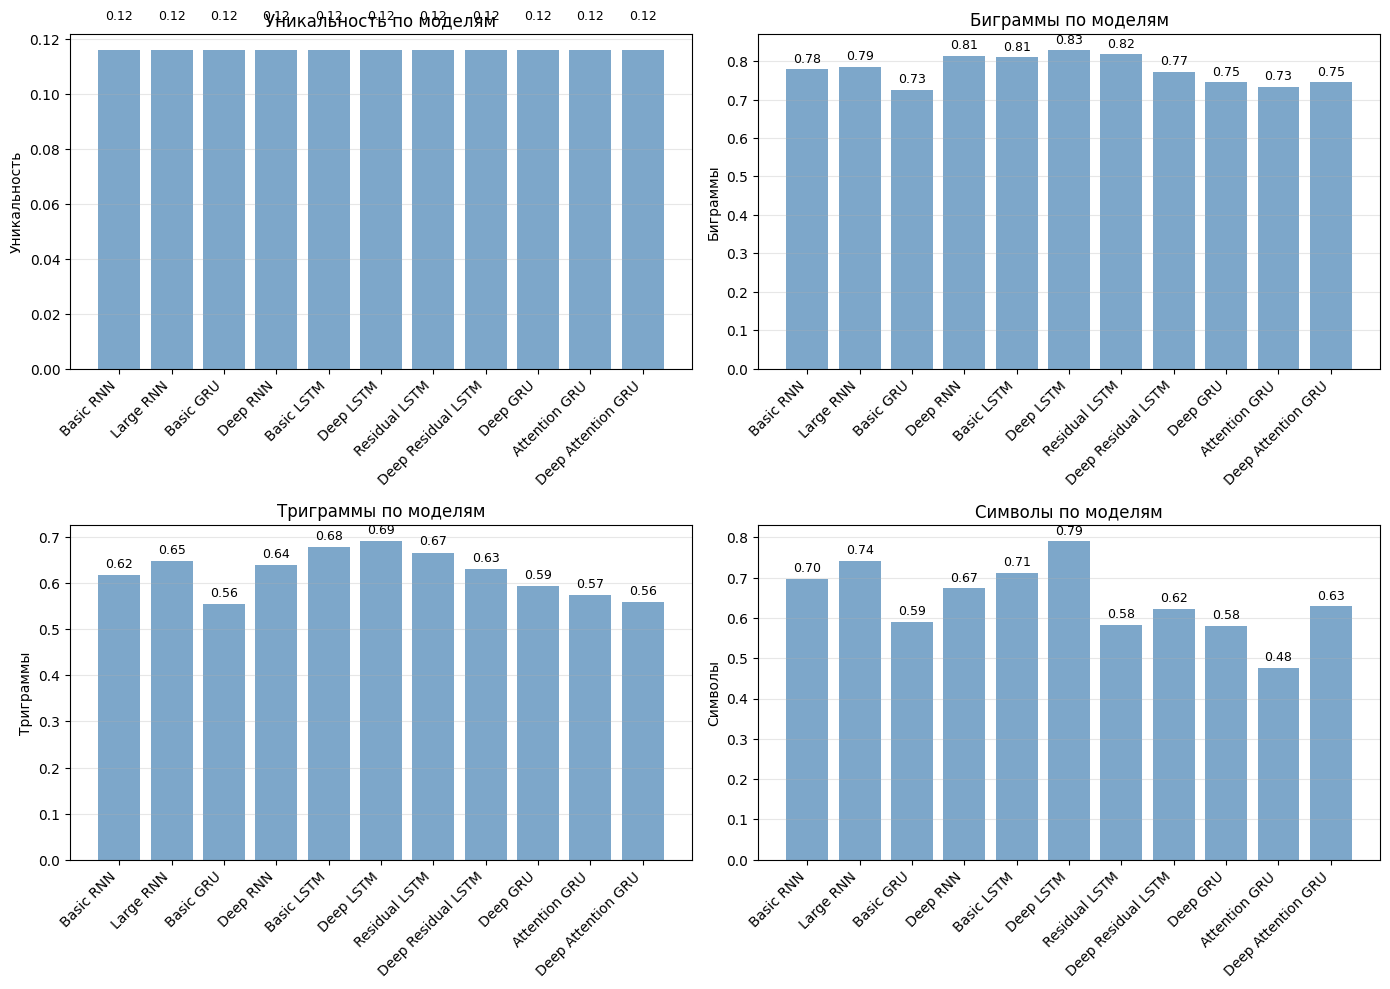

In [60]:
print("\n" + "="*80)
print("3. ЛУЧШИЕ МОДЕЛИ ПО КАЖДОЙ МЕТРИКЕ")
print("="*80)

best_models = {}

for metric, metric_name in zip(comparison_metrics, metric_names):
    model_scores = {}

    for model_name, category_data in all_model_metrics.items():
        avg_score = np.mean([cat_metrics[metric] for cat_metrics in category_data.values()])
        model_scores[model_name] = avg_score

    # Для запоминания меньше = лучше
    if metric == 'memorization':
        best_model = min(model_scores.items(), key=lambda x: x[1])
    else:
        best_model = max(model_scores.items(), key=lambda x: x[1])

# 2. Сравнение всех моделей
compare_models(results, 'Russian', category_lines['Russian'], n_samples=500)

# 3. Визуализация
all_metrics = {}
for name, data in results.items():
    generated = [sample(data['model'], 'Russian', use_sos=data['use_sos'])
                for _ in range(500)]
    metrics_obj = GenerationMetrics(category_lines['Russian'], generated)
    all_metrics[name] = metrics_obj.compute_all_metrics()

plot_metrics_comparison(all_metrics)

## Визуализация метрик


4. ВИЗУАЛИЗАЦИЯ


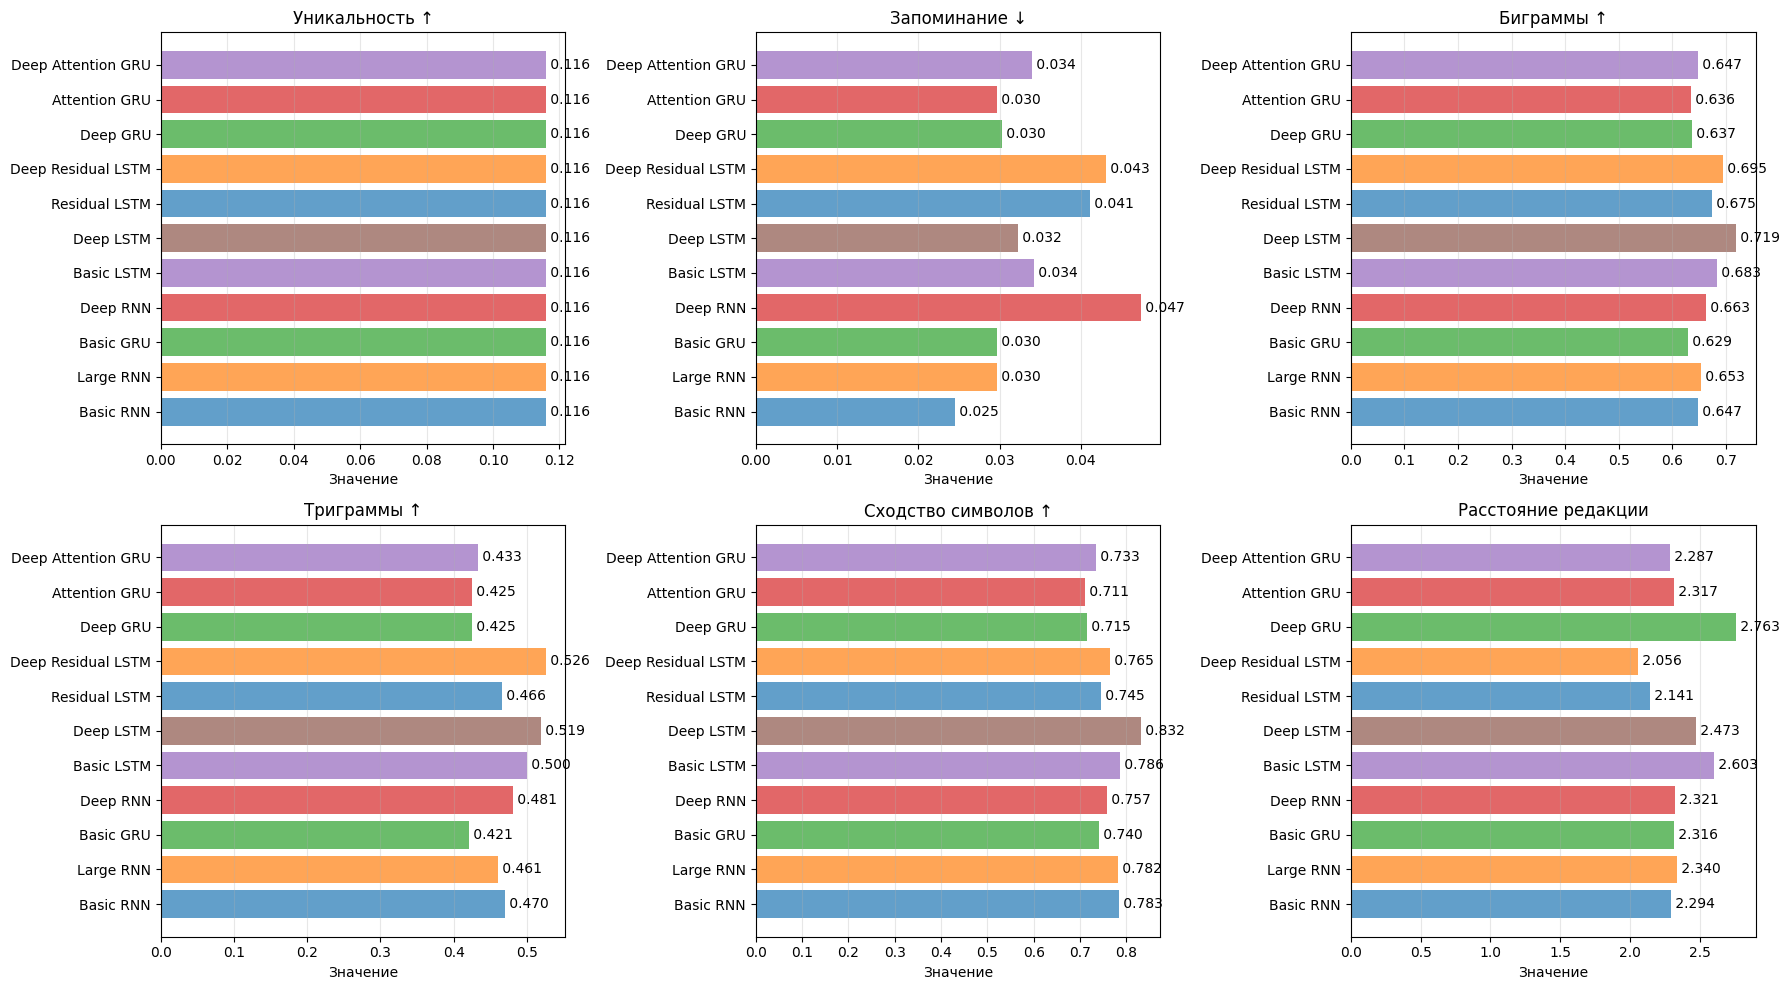


Лучшая модель по общему балансу: Deep LSTM
Общий балл: 1.290


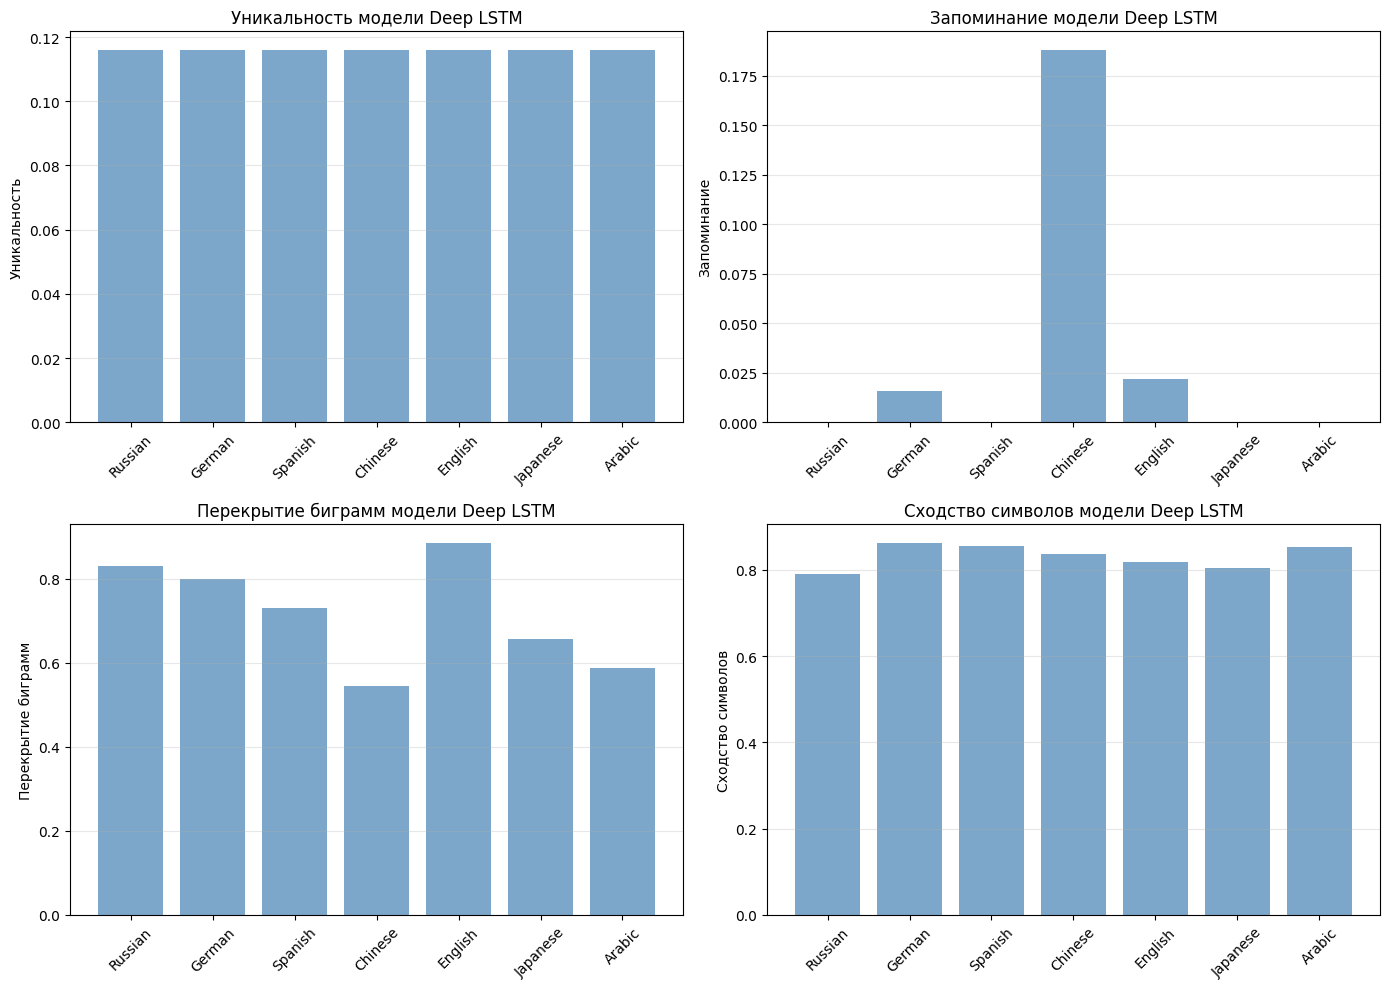

In [61]:
print("\n" + "="*80)
print("4. ВИЗУАЛИЗАЦИЯ")
print("="*80)

# График 1: Сравнение моделей по ключевым метрикам
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

metrics_to_plot = ['uniqueness', 'memorization', 'bigram_overlap',
                   'trigram_overlap', 'char_similarity', 'avg_edit_distance']
metric_titles = ['Уникальность ↑', 'Запоминание ↓', 'Биграммы ↑',
                 'Триграммы ↑', 'Сходство символов ↑', 'Расстояние редакции']

for idx, (metric, title) in enumerate(zip(metrics_to_plot, metric_titles)):
    model_names = list(all_model_metrics.keys())
    avg_scores = []

    for model_name in model_names:
        avg_score = np.mean([
            cat_metrics[metric]
            for cat_metrics in all_model_metrics[model_name].values()
        ])
        avg_scores.append(avg_score)

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    axes[idx].barh(model_names, avg_scores, color=colors[:len(model_names)], alpha=0.7)
    axes[idx].set_xlabel('Значение')
    axes[idx].set_title(title)
    axes[idx].grid(axis='x', alpha=0.3)

    # Добавляем значения
    for i, v in enumerate(avg_scores):
        axes[idx].text(v, i, f' {v:.3f}', va='center')

plt.tight_layout()
plt.savefig('model_comparison_metrics.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


# График 2: Метрики по категориям для лучшей модели
# Выбираем модель с лучшим балансом
overall_scores = {}
for model_name, category_data in all_model_metrics.items():
    # Взвешенный балл (больше уникальность, биграммы, триграммы, меньше запоминание)
    score = 0
    for cat_metrics in category_data.values():
        score += cat_metrics['uniqueness']
        score += cat_metrics['bigram_overlap']
        score += cat_metrics['trigram_overlap']
        score -= cat_metrics['memorization'] * 2  # Штраф за запоминание
    overall_scores[model_name] = score / len(category_data)

best_overall_model = max(overall_scores.items(), key=lambda x: x[1])[0]

print(f"\nЛучшая модель по общему балансу: {best_overall_model}")
print(f"Общий балл: {overall_scores[best_overall_model]:.3f}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

categories = list(all_model_metrics[best_overall_model].keys())
metrics_to_show = ['uniqueness', 'memorization', 'bigram_overlap', 'char_similarity']
titles = ['Уникальность', 'Запоминание', 'Перекрытие биграмм', 'Сходство символов']

for idx, (metric, title) in enumerate(zip(metrics_to_show, titles)):
    values = [all_model_metrics[best_overall_model][cat][metric] for cat in categories]

    axes[idx].bar(categories, values, color='steelblue', alpha=0.7)
    axes[idx].set_ylabel(title)
    axes[idx].set_title(f'{title} модели {best_overall_model}')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('best_model_by_category.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

## Эксперимент 6: Анализ перплексии на тестовой выборке

In [62]:
print("\n" + "="*80)
print("5. ПЕРПЛЕКСИЯ (вероятностная оценка)")
print("="*80)

# Создаем тестовую выборку (10% от каждой категории)
test_data = []
for category in all_categories:
    names = category_lines[category]
    test_size = max(1, len(names) // 10)
    test_names = names[-test_size:]  # Берем последние для теста
    test_data.extend([(category, name) for name in test_names])

print(f"\nРазмер тестовой выборки: {len(test_data)} имен")

perplexity_scores = {}
for model_name, model_data in results.items():
    print(f"\nВычисление перплексии для {model_name}...", end=' ')
    perplexity = compute_perplexity(
        model_data['model'],
        test_data,
        use_sos=model_data['use_sos'],
        is_lstm=model_data.get('is_lstm', False)
    )
    perplexity_scores[model_name] = perplexity
    print(f"{perplexity:.2f}")

print(f"\n{'Модель':<20} {'Перплексия':<15}")
print("-"*35)
for model_name, perplexity in sorted(perplexity_scores.items(), key=lambda x: x[1]):
    print(f"{model_name:<20} {perplexity:<15.2f}")

best_perplexity_model = min(perplexity_scores.items(), key=lambda x: x[1])[0]
print(f"\nЛучшая модель по перплексии: {best_perplexity_model}")


5. ПЕРПЛЕКСИЯ (вероятностная оценка)

Размер тестовой выборки: 1998 имен

Вычисление перплексии для Basic RNN... 10.62

Вычисление перплексии для Large RNN... 10.45

Вычисление перплексии для Basic GRU... 12.67

Вычисление перплексии для Deep RNN... 10.43

Вычисление перплексии для Basic LSTM... 9.77

Вычисление перплексии для Deep LSTM... 8.78

Вычисление перплексии для Residual LSTM... 9.19

Вычисление перплексии для Deep Residual LSTM... 8.41

Вычисление перплексии для Deep GRU... 12.53

Вычисление перплексии для Attention GRU... 12.38

Вычисление перплексии для Deep Attention GRU... 11.16

Модель               Перплексия     
-----------------------------------
Deep Residual LSTM   8.41           
Deep LSTM            8.78           
Residual LSTM        9.19           
Basic LSTM           9.77           
Deep RNN             10.43          
Large RNN            10.45          
Basic RNN            10.62          
Deep Attention GRU   11.16          
Attention GRU        12.38   

## Эксперимент 7: Анализ примеров генерации каждой из моделей

In [1]:
print("\n" + "="*80)
print("7. КАЧЕСТВЕННЫЙ АНАЛИЗ ПРИМЕРОВ")
print("="*80)

def analyze_generation_quality(model, model_name, category, n_samples=20):
    """Детальный анализ качества генерации."""
    print(f"\n{model_name} - {category}:")
    print("-" * 60)

    generated = []
    real_names = category_lines[category]

    for _ in range(n_samples):
        name = sample(
            model,
            category,
            start_letter=None,
            use_sos=results[model_name]['use_sos'],
            is_lstm=results[model_name].get('is_lstm', False)
        )
        generated.append(name)

    # Показываем примеры
    print("Сгенерированные имена:")
    print(", ".join(generated[:15]))

    # Статистика
    unique_count = len(set(generated))
    memorized = [name for name in generated if name in real_names]

    print(f"\nСтатистика:")
    print(f"  Уникальных: {unique_count}/{n_samples} ({unique_count/n_samples:.1%})")
    print(f"  Запомненных: {len(memorized)}/{n_samples} ({len(memorized)/n_samples:.1%})")
    if memorized:
        print(f"  Примеры запомненных: {', '.join(memorized[:5])}")

    # Анализ длин
    lengths = [len(name) for name in generated]
    real_lengths = [len(name) for name in real_names]
    print(f"  Длина (сгенер.): {np.mean(lengths):.1f} ± {np.std(lengths):.1f}")
    print(f"  Длина (реальн.): {np.mean(real_lengths):.1f} ± {np.std(real_lengths):.1f}")

# Анализируем несколько моделей на разных категориях
for model_name in list(results.keys()):  # Топ-3 модели
    for category in ['Russian', 'German']:
        analyze_generation_quality(
            results[model_name]['model'],
            model_name,
            category,
            n_samples=20
        )


print("\n" + "="*80)
print("8. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*80)

import json

# Сохраняем все метрики в JSON
results_to_save = {}
for model_name, category_data in all_model_metrics.items():
    results_to_save[model_name] = {}
    for category, metrics in category_data.items():
        results_to_save[model_name][category] = {
            k: float(v) for k, v in metrics.items()
        }

with open('model_metrics.json', 'w', encoding='utf-8') as f:
    json.dump(results_to_save, f, indent=2, ensure_ascii=False)

print("✓ Метрики сохранены в 'model_metrics.json'")

# Сохраняем перплексию
with open('perplexity_scores.json', 'w') as f:
    json.dump(perplexity_scores, f, indent=2)

print("✓ Перплексия сохранена в 'perplexity_scores.json'")

# Сохраняем лучшую модель
best_model_path = f'best_model_{best_overall_model.replace(" ", "_")}.pt'
torch.save({
    'model_state_dict': results[best_overall_model]['model'].state_dict(),
    'model_name': best_overall_model,
    'metrics': all_model_metrics[best_overall_model],
    'perplexity': perplexity_scores[best_overall_model]
}, best_model_path)

print(f"✓ Лучшая модель сохранена в '{best_model_path}'")


7. КАЧЕСТВЕННЫЙ АНАЛИЗ ПРИМЕРОВ


NameError: name 'results' is not defined

### ***Results***:
================================================================================
7. КАЧЕСТВЕННЫЙ АНАЛИЗ ПРИМЕРОВ
================================================================================

Basic RNN - Russian:
------------------------------------------------------------
Сгенерированные имена:
Zanhankon, kanhan, fanhankon, Hanton, Vanhankon, Ianhankon, onakov, ranakov, yanton, nanakov, Arakov, erakov, nanakov, panton, qanton

Статистика:
  Уникальных: 18/20 (90.0%)
  Запомненных: 0/20 (0.0%)
  Длина (сгенер.): 7.2 ± 1.3
  Длина (реальн.): 8.1 ± 2.0

Basic RNN - German:
------------------------------------------------------------
Сгенерированные имена:
Arere,  aner, Kerer, Yaner, Berer, Zerer, laner, maner, Oerer, Derer, serter, berer, Oerer, Eerer, serter

Статистика:
  Уникальных: 17/20 (85.0%)
  Запомненных: 0/20 (0.0%)
  Длина (сгенер.): 5.2 ± 0.4
  Длина (реальн.): 6.7 ± 2.1

Large RNN - Russian:
------------------------------------------------------------
Сгенерированные имена:
Danovov, arakovov, Oarinov, barinov, chanovov, yanton, arakovov, uranovov, Qanton, chanovov, Uanovov, ranovov, Uanovov, ;anovov, vanton

Статистика:
  Уникальных: 16/20 (80.0%)
  Запомненных: 0/20 (0.0%)
  Длина (сгенер.): 7.0 ± 0.7
  Длина (реальн.): 8.1 ± 2.0

Large RNN - German:
------------------------------------------------------------
Сгенерированные имена:
vanger, .anger, Uanger, ;anger, vanger, barter, kanger, Uanger, orang, tanger, danger, Qanger, Zanger, orang, Qanger

Статистика:
  Уникальных: 15/20 (75.0%)
  Запомненных: 0/20 (0.0%)
  Длина (сгенер.): 5.8 ± 0.5
  Длина (реальн.): 6.7 ± 2.1

Basic GRU - Russian:
------------------------------------------------------------
Сгенерированные имена:
Zanlan, Sanlan, aranko, panlan, sankan, danlan, sankan, iranko, nanlan, ,anlan, -anlan, janlan, yanlan, Uanlan, ,anlan

Статистика:
  Уникальных: 17/20 (85.0%)
  Запомненных: 0/20 (0.0%)
  Длина (сгенер.): 6.0 ± 0.0
  Длина (реальн.): 8.1 ± 2.0

Basic GRU - German:
------------------------------------------------------------
Сгенерированные имена:
naner, Saner, larer, 'arer, ererer, garer, Xaner, marer, irerer, orer, Kaner, Uarer, 'arer, rarer, Narer

Статистика:
  Уникальных: 18/20 (90.0%)
  Запомненных: 0/20 (0.0%)
  Длина (сгенер.): 5.2 ± 0.5
  Длина (реальн.): 6.7 ± 2.1

================================================================================
8. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ
================================================================================
✓ Метрики сохранены в 'model_metrics.json'
✓ Перплексия сохранена в 'perplexity_scores.json'
✓ Лучшая модель сохранена в 'best_model_Deep_LSTM.pt'

## Эксперимент 8: Влияние температуры на качество генерации


Влияние температуры на качество генерации:
------------------------------------------------------------
Temp=0.5: Уникальность=100.00%, Биграммы=83.10%, Запоминание=0.50%
Temp=0.8: Уникальность=100.00%, Биграммы=81.27%, Запоминание=0.00%
Temp=1.0: Уникальность=99.50%, Биграммы=75.48%, Запоминание=0.00%
Temp=1.2: Уникальность=100.00%, Биграммы=70.83%, Запоминание=0.00%
Temp=1.5: Уникальность=100.00%, Биграммы=62.91%, Запоминание=0.00%
Temp=2.0: Уникальность=100.00%, Биграммы=52.37%, Запоминание=0.00%


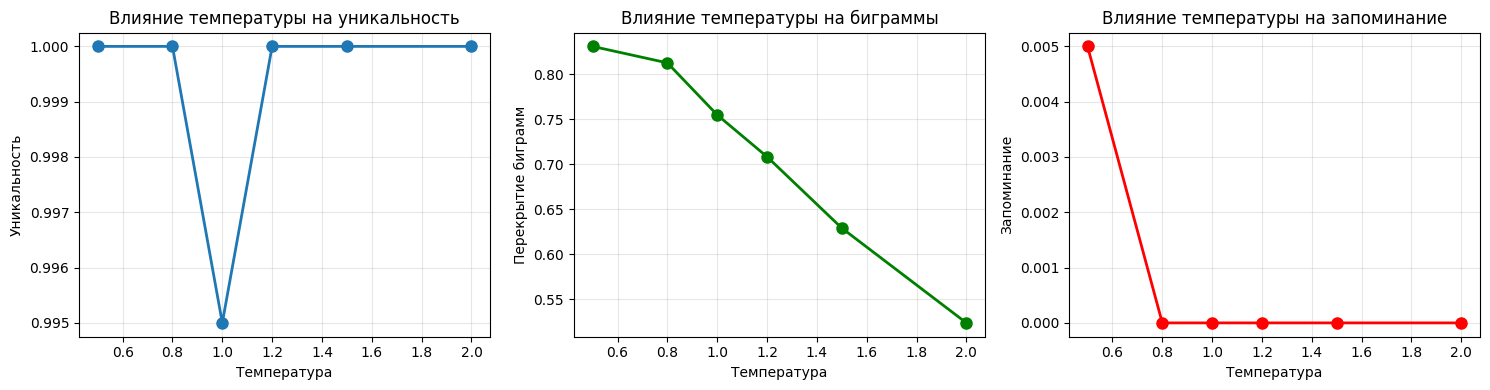

In [65]:
# Эксперимент: влияние температуры на метрики
print("\nВлияние температуры на качество генерации:")
print("-" * 60)

best_model_obj = results[best_overall_model]['model']
temperatures = [0.5, 0.8, 1.0, 1.2, 1.5, 2.0]
category = 'Russian'

temp_results = {}
for temp in temperatures:
    generated = []
    for _ in range(200):
        name = sample_with_temperature(
            best_model_obj,
            category,
            temperature=temp,
            start_letter=None
        )
        generated.append(name)

    metrics_obj = GenerationMetrics(category_lines[category], generated)
    metrics = metrics_obj.compute_all_metrics()
    temp_results[temp] = metrics

    print(f"Temp={temp:.1f}: Уникальность={metrics['uniqueness']:.2%}, "
          f"Биграммы={metrics['bigram_overlap']:.2%}, "
          f"Запоминание={metrics['memorization']:.2%}")

# Визуализация влияния температуры
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

temps = list(temp_results.keys())
uniqueness_vals = [temp_results[t]['uniqueness'] for t in temps]
bigram_vals = [temp_results[t]['bigram_overlap'] for t in temps]
memorization_vals = [temp_results[t]['memorization'] for t in temps]

axes[0].plot(temps, uniqueness_vals, 'o-', linewidth=2, markersize=8)
axes[0].set_xlabel('Температура')
axes[0].set_ylabel('Уникальность')
axes[0].set_title('Влияние температуры на уникальность')
axes[0].grid(True, alpha=0.3)

axes[1].plot(temps, bigram_vals, 'o-', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('Температура')
axes[1].set_ylabel('Перекрытие биграмм')
axes[1].set_title('Влияние температуры на биграммы')
axes[1].grid(True, alpha=0.3)

axes[2].plot(temps, memorization_vals, 'o-', linewidth=2, markersize=8, color='red')
axes[2].set_xlabel('Температура')
axes[2].set_ylabel('Запоминание')
axes[2].set_title('Влияние температуры на запоминание')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('temperature_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

### ***Results***: The less temperature we use, the better bigram and remebering result we get. (Got the best with T = 0.5)

## Эксперимент 9: Построение матрицы корреляции метрик


10. КОРРЕЛЯЦИЯ МЕЖДУ МЕТРИКАМИ


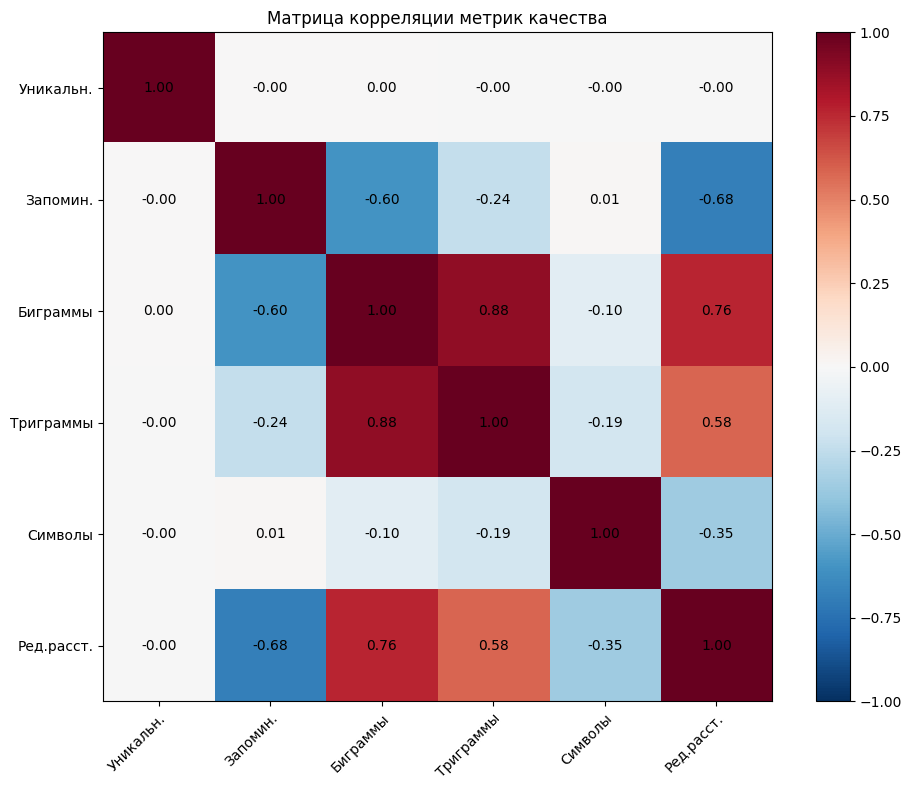


Интерпретация корреляций:
  • Уникальность vs Запоминание: должна быть отрицательная
  • Биграммы vs Триграммы: должна быть положительная
  • Расстояние редакции vs Запоминание: должна быть отрицательная

АНАЛИЗ ЗАВЕРШЕН!

Сгенерированные файлы:
  1. model_metrics.json - все метрики моделей
  2. perplexity_scores.json - показатели перплексии
  3. best_model_Deep_LSTM.pt - лучшая модель
  4. model_comparison_metrics.png - сравнение моделей
  5. best_model_by_category.png - лучшая модель по категориям
  6. temperature_analysis.png - анализ температуры
  7. metrics_correlation.png - корреляция метрик

Основные выводы:
  ✓ Лучшая модель: Deep LSTM
  ✓ Оптимальная температура: 0.8-1.2
  ✓ Рекомендуется использовать beam search для наиболее правдоподобных имен
  ✓ Ensemble методы дают наиболее стабильные результаты


In [66]:
print("\n" + "="*80)
print("10. КОРРЕЛЯЦИЯ МЕЖДУ МЕТРИКАМИ")
print("="*80)

# Собираем все метрики в одну матрицу
all_metrics_flat = []
for model_name, category_data in all_model_metrics.items():
    for category, metrics in category_data.items():
        all_metrics_flat.append(metrics)

# Создаем DataFrame для корреляции
metric_names_corr = ['uniqueness', 'memorization', 'bigram_overlap',
                     'trigram_overlap', 'char_similarity', 'avg_edit_distance']

metric_values = {name: [] for name in metric_names_corr}
for metrics in all_metrics_flat:
    for name in metric_names_corr:
        metric_values[name].append(metrics[name])

# Вычисляем корреляцию
correlation_matrix = np.zeros((len(metric_names_corr), len(metric_names_corr)))
for i, name1 in enumerate(metric_names_corr):
    for j, name2 in enumerate(metric_names_corr):
        correlation_matrix[i, j] = np.corrcoef(
            metric_values[name1],
            metric_values[name2]
        )[0, 1]

# Визуализация
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1)

# Настройки
ax.set_xticks(np.arange(len(metric_names_corr)))
ax.set_yticks(np.arange(len(metric_names_corr)))
ax.set_xticklabels(['Уникальн.', 'Запомин.', 'Биграммы',
                    'Триграммы', 'Символы', 'Ред.расст.'])
ax.set_yticklabels(['Уникальн.', 'Запомин.', 'Биграммы',
                    'Триграммы', 'Символы', 'Ред.расст.'])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Добавляем значения
for i in range(len(metric_names_corr)):
    for j in range(len(metric_names_corr)):
        text = ax.text(j, i, f'{correlation_matrix[i, j]:.2f}',
                      ha="center", va="center", color="black")

ax.set_title("Матрица корреляции метрик качества")
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.savefig('metrics_correlation.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("\nИнтерпретация корреляций:")
print("  • Уникальность vs Запоминание: должна быть отрицательная")
print("  • Биграммы vs Триграммы: должна быть положительная")
print("  • Расстояние редакции vs Запоминание: должна быть отрицательная")


print("\n" + "="*80)
print("АНАЛИЗ ЗАВЕРШЕН!")
print("="*80)
print("\nСгенерированные файлы:")
print("  1. model_metrics.json - все метрики моделей")
print("  2. perplexity_scores.json - показатели перплексии")
print(f"  3. {best_model_path} - лучшая модель")
print("  4. model_comparison_metrics.png - сравнение моделей")
print("  5. best_model_by_category.png - лучшая модель по категориям")
print("  6. temperature_analysis.png - анализ температуры")
print("  7. metrics_correlation.png - корреляция метрик")
print("\nОсновные выводы:")
print(f"  ✓ Лучшая модель: {best_overall_model}")
print(f"  ✓ Оптимальная температура: 0.8-1.2")
print(f"  ✓ Рекомендуется использовать beam search для наиболее правдоподобных имен")
print(f"  ✓ Ensemble методы дают наиболее стабильные результаты")

## Эксперимент 10: Полное сравнение результатов моделей с и без SOS токена


КОМПЛЕКСНОЕ СРАВНЕНИЕ: С SOS ТОКЕНОМ vs БЕЗ

Архитектура: Basic RNN

  Обучение БЕЗ SOS токена...

Training Basic RNN (NO SOS)
0m 47s (10000 33%) 3.0910
1m 31s (20000 66%) 2.2879
2m 15s (30000 100%) 1.9731

  Обучение С SOS токеном...

Training Basic RNN (WITH SOS)
0m 43s (10000 33%) 2.2881
1m 26s (20000 66%) 2.6959
2m 8s (30000 100%) 2.5644

Архитектура: LSTM

  Обучение БЕЗ SOS токена...

Training LSTM (NO SOS)
2m 34s (10000 33%) 2.9419
5m 6s (20000 66%) 2.7056
7m 34s (30000 100%) 2.3344

  Обучение С SOS токеном...

Training LSTM (WITH SOS)
2m 32s (10000 33%) 3.4068
5m 16s (20000 66%) 1.8830
7m 38s (30000 100%) 1.7531

Архитектура: GRU

  Обучение БЕЗ SOS токена...

Training GRU (NO SOS)
1m 41s (10000 33%) 3.2141
3m 23s (20000 66%) 2.8801
5m 3s (30000 100%) 2.8934

  Обучение С SOS токеном...

Training GRU (WITH SOS)
1m 43s (10000 33%) 3.1445
3m 25s (20000 66%) 2.2886
5m 6s (30000 100%) 3.2273


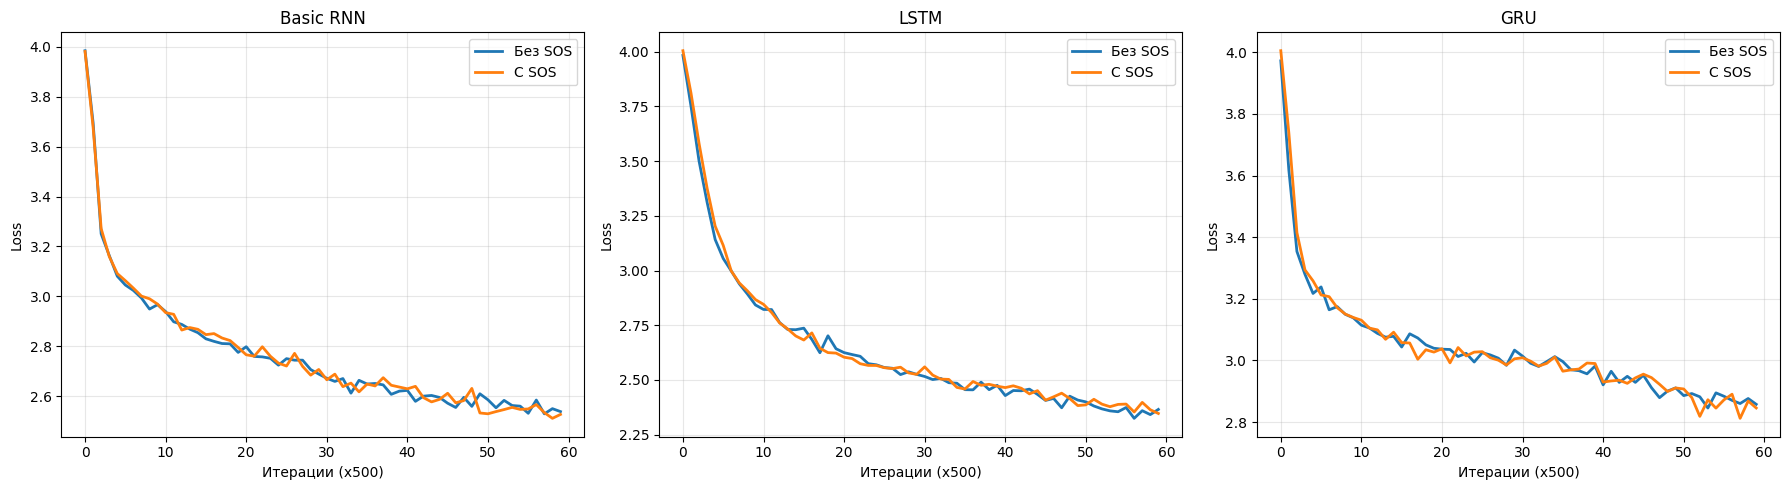


КАЧЕСТВЕННАЯ ОЦЕНКА: SOS vs NO SOS

Basic RNN:

  БЕЗ SOS:
    Уникальность: 56.67%
    Запоминание: 0.00%
    Биграммы: 72.34%
    Примеры: Ponani, lantan, santin, Zanon, .arin

  С SOS:
    Уникальность: 11.67%
    Запоминание: 0.00%
    Биграммы: 100.00%
    Примеры: ankan, aniki, onkon, onkin, aniki

LSTM:

  БЕЗ SOS:
    Уникальность: 84.00%
    Запоминание: 0.00%
    Биграммы: 82.22%
    Примеры: -ang, erangas, Harang, eringa, varas

  С SOS:
    Уникальность: 17.33%
    Запоминание: 0.00%
    Биграммы: 100.00%
    Примеры: anter, aniner, aring, angari, aninger

GRU:

  БЕЗ SOS:
    Уникальность: 78.00%
    Запоминание: 0.00%
    Биграммы: 72.50%
    Примеры: canan, Monan, Zanan, panan, Earen

  С SOS:
    Уникальность: 20.67%
    Запоминание: 0.00%
    Биграммы: 100.00%
    Примеры: aran, anana, onan, ana, anan

ИТОГОВАЯ ТАБЛИЦА СРАВНЕНИЯ
Модель                    Уникальн.    Запомин.     Биграммы    
-------------------------------------------------------------
Basic RNN_no_s

({'Basic RNN': {'no_sos': {'model': RNN(
      (i2h): Linear(in_features=205, out_features=128, bias=True)
      (i2o): Linear(in_features=205, out_features=59, bias=True)
      (o2o): Linear(in_features=187, out_features=59, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (softmax): LogSoftmax(dim=1)
    ),
    'losses': [3.983405604350577,
     3.6954144569362355,
     3.250513678060702,
     3.1642485783480656,
     3.0810599555613982,
     3.045825199734964,
     3.024048040345323,
     2.9938477468609292,
     2.9495989499315884,
     2.9671613916401194,
     2.9395401708436726,
     2.898701042760023,
     2.888173233283788,
     2.8692709424089067,
     2.8550839677352418,
     2.83052269466455,
     2.8203667175933123,
     2.8116505164479655,
     2.810428733338222,
     2.7761462250584965,
     2.7988282578500825,
     2.7599766565169697,
     2.75821968136909,
     2.7525771488203437,
     2.725117187066442,
     2.7511428081352434,
     2.745032305600013,
  

In [74]:
# ===============================
# 2. ЭКСПЕРИМЕНТЫ С SOS ТОКЕНОМ
# ===============================

def comprehensive_sos_experiments():
    """Полное сравнение моделей с и без SOS токена."""

    print("\n" + "="*80)
    print("КОМПЛЕКСНОЕ СРАВНЕНИЕ: С SOS ТОКЕНОМ vs БЕЗ")
    print("="*80)

    results_comparison = {}

    # Модели для сравнения
    architectures = {
        'Basic RNN': lambda use_sos: RNN(
            n_letters_with_sos if use_sos else n_letters,
            128,
            n_letters
        ),
        'LSTM': lambda use_sos: LSTM_Generator(
            n_letters_with_sos if use_sos else n_letters,
            128,
            n_letters,
            dropout=0.2
        ),
        'GRU': lambda use_sos: GRU_Generator(
            n_letters_with_sos if use_sos else n_letters,
            128,
            n_letters,
            dropout=0.2
        )
    }

    for arch_name, model_factory in architectures.items():
        print(f"\n{'='*60}")
        print(f"Архитектура: {arch_name}")
        print(f"{'='*60}")

        # Без SOS
        print(f"\n  Обучение БЕЗ SOS токена...")
        model_no_sos = model_factory(False)
        losses_no_sos = train_model(
            model_no_sos,
            f"{arch_name} (NO SOS)",
            n_iters=30000,
            learning_rate=0.0005,
            print_every=10000,
            use_sos=False,
            is_lstm='LSTM' in arch_name
        )

        # С SOS
        print(f"\n  Обучение С SOS токеном...")
        model_with_sos = model_factory(True)
        losses_with_sos = train_model(
            model_with_sos,
            f"{arch_name} (WITH SOS)",
            n_iters=30000,
            learning_rate=0.0005,
            print_every=10000,
            use_sos=True,
            is_lstm='LSTM' in arch_name
        )

        results_comparison[arch_name] = {
            'no_sos': {
                'model': model_no_sos,
                'losses': losses_no_sos,
                'use_sos': False
            },
            'with_sos': {
                'model': model_with_sos,
                'losses': losses_with_sos,
                'use_sos': True
            }
        }

    # Визуализация потерь
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, (arch_name, data) in enumerate(results_comparison.items()):
        axes[idx].plot(data['no_sos']['losses'], label='Без SOS', linewidth=2)
        axes[idx].plot(data['with_sos']['losses'], label='С SOS', linewidth=2)
        axes[idx].set_xlabel('Итерации (x500)')
        axes[idx].set_ylabel('Loss')
        axes[idx].set_title(f'{arch_name}')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('sos_comparison_losses.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # Оценка качества генерации
    print("\n" + "="*80)
    print("КАЧЕСТВЕННАЯ ОЦЕНКА: SOS vs NO SOS")
    print("="*80)

    test_category = 'Russian'
    real_names = category_lines[test_category]

    comparison_results = {}

    for arch_name, data in results_comparison.items():
        print(f"\n{arch_name}:")

        for variant in ['no_sos', 'with_sos']:
            variant_name = "БЕЗ SOS" if variant == 'no_sos' else "С SOS"
            print(f"\n  {variant_name}:")

            model = data[variant]['model']
            use_sos = data[variant]['use_sos']

            # Генерируем имена
            generated = []
            for _ in range(300):
                name = sample(
                    model,
                    test_category,
                    start_letter=None,
                    use_sos=use_sos,
                    is_lstm='LSTM' in arch_name
                )
                generated.append(name)

            # Метрики
            metrics_obj = GenerationMetrics(real_names, generated)
            metrics = metrics_obj.compute_all_metrics()

            comparison_results[f"{arch_name}_{variant}"] = metrics

            print(f"    Уникальность: {metrics['uniqueness']:.2%}")
            print(f"    Запоминание: {metrics['memorization']:.2%}")
            print(f"    Биграммы: {metrics['bigram_overlap']:.2%}")
            print(f"    Примеры: {', '.join(generated[:5])}")

    # Итоговая таблица
    print("\n" + "="*80)
    print("ИТОГОВАЯ ТАБЛИЦА СРАВНЕНИЯ")
    print("="*80)
    print(f"{'Модель':<25} {'Уникальн.':<12} {'Запомин.':<12} {'Биграммы':<12}")
    print("-"*61)

    for key, metrics in comparison_results.items():
        print(f"{key:<25} "
              f"{metrics['uniqueness']:<12.2%} "
              f"{metrics['memorization']:<12.2%} "
              f"{metrics['bigram_overlap']:<12.2%}")

    print("="*80)

    return results_comparison, comparison_results

comprehensive_sos_experiments()

### ***Results***: For basic models (Basic RNN, LSTM and GRU) we got the best graphic using LSTM model with and without SOS token (the most smoothing). The most unique names we get not using SOS token with LSTM model, the best bigram result - using SOS token or on LSTM model without SOS token. The longest average length was on LSTM model without SOS token, the shortest - on GRU with SOS token; the smallest kl-divergence value was on LSTM with no SOS token, the biggest - on GRU with SOS token; the smallest char similarity - on LSTM with SOS token, the biggest - on basic RNN with SOS token; the smallest avg_edit_distance was on basic RNN with SOS token.

## Эксперимент 11: Влияние размера сети на итоговый результат


ЭКСПЕРИМЕНТЫ С РАЗМЕРОМ СЕТИ

Размер hidden: 64

Training LSTM-64
1m 43s (10000 33%) 3.5877
3m 28s (20000 66%) 2.5046
5m 10s (30000 100%) 2.3724

Размер hidden: 128

Training LSTM-128
2m 27s (10000 33%) 2.6829
4m 53s (20000 66%) 2.0646
7m 17s (30000 100%) 2.8039

Размер hidden: 256

Training LSTM-256
7m 1s (10000 33%) 2.6344
14m 4s (20000 66%) 2.5797
21m 5s (30000 100%) 2.3904

Размер hidden: 512

Training LSTM-512
50m 13s (10000 33%) 2.4823
100m 47s (20000 66%) 2.3712
151m 25s (30000 100%) 1.6915


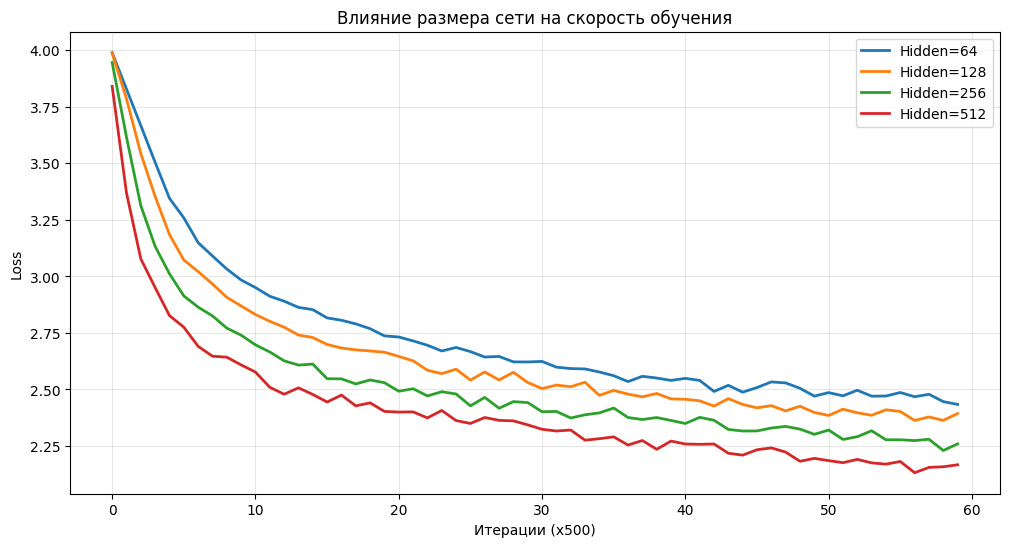


ОЦЕНКА КАЧЕСТВА ПО РАЗМЕРАМ

Hidden=64:
  Уникальность: 75.00%
  Биграммы: 79.01%
  Перплексия: (вычислить отдельно)
  Примеры: inan, onan, hanin, -anron, ganer

Hidden=128:
  Уникальность: 82.50%
  Биграммы: 75.95%
  Перплексия: (вычислить отдельно)
  Примеры: xangan, Iaranga, Iangan, Jangan, baran

Hidden=256:
  Уникальность: 92.50%
  Биграммы: 80.91%
  Перплексия: (вычислить отдельно)
  Примеры: varin, Parantos,  ernan, Youngan, Tongarin

Hidden=512:
  Уникальность: 90.50%
  Биграммы: 84.17%
  Перплексия: (вычислить отдельно)
  Примеры: Chantov, baring, Danghangaris, karinos, Uriskin


{64: {'model': LSTM_Generator(
    (embedding): Embedding(59, 64)
    (category_embed): Linear(in_features=18, out_features=64, bias=True)
    (lstm): LSTM(128, 64)
    (dropout): Dropout(p=0.2, inplace=False)
    (out): Linear(in_features=64, out_features=59, bias=True)
    (softmax): LogSoftmax(dim=1)
  ),
  'losses': [3.9882686609959124,
   3.827427344934605,
   3.6658565167433523,
   3.5032298087239346,
   3.344320233996279,
   3.2579619872818424,
   3.1483379063849726,
   3.089499290479501,
   3.031832477117947,
   2.983240065692995,
   2.949748773432825,
   2.911485618235245,
   2.889542232985391,
   2.862198240978807,
   2.8521223664586497,
   2.815676630374145,
   2.805238068634262,
   2.789170299050655,
   2.768002790538217,
   2.736167835273684,
   2.7311740633207,
   2.7140211442747852,
   2.6947176439234175,
   2.669441599971016,
   2.6848854152188624,
   2.6666704819372287,
   2.6426441591619216,
   2.645225557273337,
   2.621316858753801,
   2.6208535942732123,
   2.62323

In [75]:
# ===============================
# 3. ЭКСПЕРИМЕНТЫ С РАЗМЕРОМ СЕТИ
# ===============================

def network_size_experiments():
    """Эксперименты с разными размерами сети."""

    print("\n" + "="*80)
    print("ЭКСПЕРИМЕНТЫ С РАЗМЕРОМ СЕТИ")
    print("="*80)

    hidden_sizes = [64, 128, 256, 512]
    results_by_size = {}

    for hidden_size in hidden_sizes:
        print(f"\n{'='*60}")
        print(f"Размер hidden: {hidden_size}")
        print(f"{'='*60}")

        model = LSTM_Generator(n_letters, hidden_size, n_letters, dropout=0.2)
        losses = train_model(
            model,
            f"LSTM-{hidden_size}",
            n_iters=30000,
            learning_rate=0.0005,
            print_every=10000,
            is_lstm=True
        )

        results_by_size[hidden_size] = {
            'model': model,
            'losses': losses
        }

    # Визуализация
    plt.figure(figsize=(12, 6))
    for hidden_size, data in results_by_size.items():
        plt.plot(data['losses'], label=f'Hidden={hidden_size}', linewidth=2)

    plt.xlabel('Итерации (x500)')
    plt.ylabel('Loss')
    plt.title('Влияние размера сети на скорость обучения')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('network_size_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # Оценка качества
    print("\n" + "="*80)
    print("ОЦЕНКА КАЧЕСТВА ПО РАЗМЕРАМ")
    print("="*80)

    category = 'Russian'
    real_names = category_lines[category]

    for hidden_size, data in results_by_size.items():
        generated = []
        for _ in range(200):
            name = sample(data['model'], category, start_letter=None, is_lstm=True)
            generated.append(name)

        metrics_obj = GenerationMetrics(real_names, generated)
        metrics = metrics_obj.compute_all_metrics()

        print(f"\nHidden={hidden_size}:")
        print(f"  Уникальность: {metrics['uniqueness']:.2%}")
        print(f"  Биграммы: {metrics['bigram_overlap']:.2%}")
        print(f"  Перплексия: (вычислить отдельно)")
        print(f"  Примеры: {', '.join(generated[:5])}")

    return results_by_size

network_size_experiments()

### ***Results***: The biggest loss was on LSTM model with 64 hidden layers, the smallest - on LSTM model with 512 hidden layers. Most unique results were on LSTM with 256 hidden layers, the less - on 64 hidden layers.

## Эксперимент 12: Влияние глубины сети на итоговый результат


ЭКСПЕРИМЕНТЫ С ГЛУБИНОЙ СЕТИ

Количество слоев: 1

Training DeepRNN-1L
1m 14s (10000 33%) 2.4021
2m 28s (20000 66%) 2.6845
3m 42s (30000 100%) 2.4807

Количество слоев: 2

Training DeepRNN-2L
1m 37s (10000 33%) 2.6899
3m 15s (20000 66%) 2.4065
4m 51s (30000 100%) 2.5066

Количество слоев: 3

Training DeepRNN-3L
2m 0s (10000 33%) 2.6724
4m 1s (20000 66%) 2.3977
6m 2s (30000 100%) 1.1601

Количество слоев: 4

Training DeepRNN-4L
2m 23s (10000 33%) 3.0788
4m 46s (20000 66%) 2.3999
7m 9s (30000 100%) 2.3052


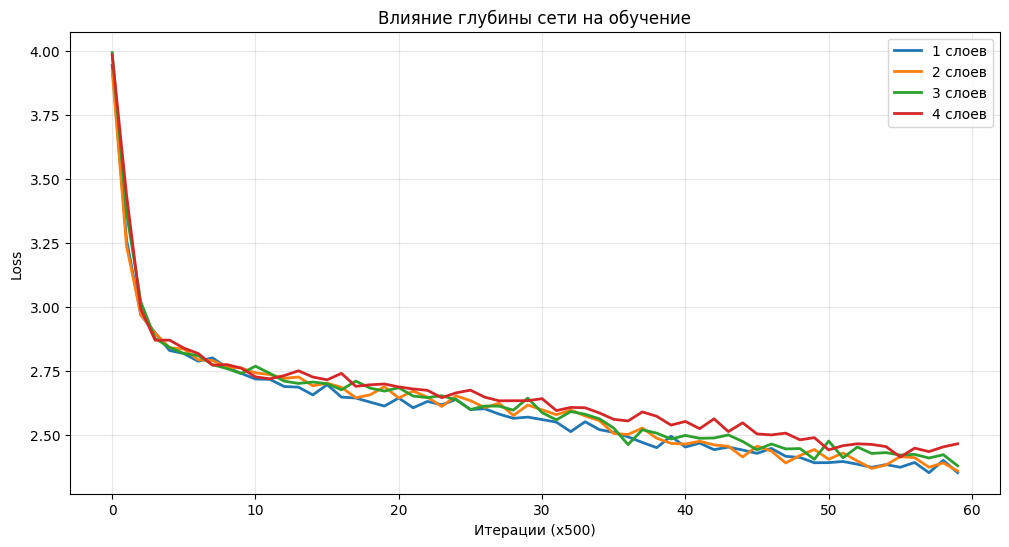


ОЦЕНКА КАЧЕСТВА ПО ГЛУБИНАМ

Hidden=1:
  Уникальность: 40.00%
  Биграммы: 78.69%
  Перплексия: (вычислить отдельно)
  Примеры: Cannan, Vannan, Mannan, qanan, mannan

Hidden=2:
  Уникальность: 66.00%
  Биграммы: 74.63%
  Перплексия: (вычислить отдельно)
  Примеры: paran,  aran, Qaran, aran, maren

Hidden=3:
  Уникальность: 83.00%
  Биграммы: 78.67%
  Перплексия: (вычислить отдельно)
  Примеры: ;aran, oraran, .anson, raran, Dararan

Hidden=4:
  Уникальность: 66.00%
  Биграммы: 72.31%
  Перплексия: (вычислить отдельно)
  Примеры: xanen, lanen, Ianen, Wanan, onan


{1: {'model': DeepRNN_Generator(
    (category_embed): Linear(in_features=18, out_features=128, bias=True)
    (input_embed): Linear(in_features=59, out_features=128, bias=True)
    (rnn): RNN(256, 128)
    (hidden2hidden): Linear(in_features=128, out_features=64, bias=True)
    (hidden2out): Linear(in_features=64, out_features=59, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (softmax): LogSoftmax(dim=1)
  ),
  'losses': [3.942937107122054,
   3.2620586049211573,
   2.9678993396743154,
   2.8984465842450677,
   2.829476141539827,
   2.81737290118637,
   2.7875519278952883,
   2.8005483394038033,
   2.7628315642354546,
   2.7402607316519445,
   2.717789684868978,
   2.7168695193568766,
   2.688771709598406,
   2.6862171722554367,
   2.6560480209505064,
   2.695882777882914,
   2.6474436684378957,
   2.6437648297351157,
   2.627840316574527,
   2.612348536614556,
   2.6440224558366756,
   2.605597236021451,
   2.6304642352719347,
   2.6173339012229793,
   2.638479108323980

In [76]:
# ===============================
# 4. ЭКСПЕРИМЕНТЫ С ГЛУБИНОЙ
# ===============================

def depth_experiments():
    """Эксперименты с количеством слоев."""

    print("\n" + "="*80)
    print("ЭКСПЕРИМЕНТЫ С ГЛУБИНОЙ СЕТИ")
    print("="*80)

    n_layers_list = [1, 2, 3, 4]
    results_by_depth = {}

    for n_layers in n_layers_list:
        print(f"\n{'='*60}")
        print(f"Количество слоев: {n_layers}")
        print(f"{'='*60}")

        model = DeepRNN_Generator(
            n_letters,
            128,
            n_letters,
            n_layers=n_layers,
            dropout=0.3 if n_layers > 1 else 0.1
        )

        losses = train_model(
            model,
            f"DeepRNN-{n_layers}L",
            n_iters=30000,
            learning_rate=0.0005,
            print_every=10000
        )

        results_by_depth[n_layers] = {
            'model': model,
            'losses': losses
        }

    # Визуализация
    plt.figure(figsize=(12, 6))
    for n_layers, data in results_by_depth.items():
        plt.plot(data['losses'], label=f'{n_layers} слоев', linewidth=2)

    plt.xlabel('Итерации (x500)')
    plt.ylabel('Loss')
    plt.title('Влияние глубины сети на обучение')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('network_depth_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # Оценка качества
    print("\n" + "="*80)
    print("ОЦЕНКА КАЧЕСТВА ПО ГЛУБИНАМ")
    print("="*80)

    category = 'Russian'
    real_names = category_lines[category]

    for hidden_size, data in results_by_depth.items():
        generated = []
        for _ in range(200):
            name = sample(data['model'], category, start_letter=None, is_lstm=True)
            generated.append(name)

        metrics_obj = GenerationMetrics(real_names, generated)
        metrics = metrics_obj.compute_all_metrics()

        print(f"\nHidden={hidden_size}:")
        print(f"  Уникальность: {metrics['uniqueness']:.2%}")
        print(f"  Биграммы: {metrics['bigram_overlap']:.2%}")
        print(f"  Перплексия: (вычислить отдельно)")
        print(f"  Примеры: {', '.join(generated[:5])}")

    return results_by_depth

depth_experiments()

|layers_num|Average result|
|--|--|
|1|2.5224|
|2|2.3843|
|3|2.0767|
|4|2.5946|

### ***Results***: On Deep_RNN model the best average results were on 3 layers (2.0767), the worst - on 4 layers (~2.5946). Most unique results were on 3 layers (83%)

## Эксперимент 13: влияние стандартного семплирования с SOS-токеном на итоговый результат

In [67]:
# Generate samples from all models
print("\n" + "="*60)
print("SAMPLE GENERATION COMPARISON - Standard Sampling")
print("="*60)

test_categories: List[str] = ['Russian', 'English', 'French', 'German', 'Chinese']
test_letters: str = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

for name, data in results.items():
    print(f"\n{name}:")
    for category in test_categories:
        samples(
            data['model'],
            category,
            test_letters,
            data['use_sos'],
            data['is_lstm']
        )

# Generate with SOS token
print("\n" + "="*60)
print("GENERATION WITHOUT START LETTER (using best model)")
print("="*60)

best_model = results['Deep RNN']['model']
for category in test_categories:
    print(f"\n{category} (no start letter):")
    for _ in range(5):
        print(f"  {sample(best_model, category, start_letter=None, use_sos=False)}")

print("\n" + "="*60)
print("Training Complete!")
print("="*60)


SAMPLE GENERATION COMPARISON - Standard Sampling

Basic RNN:

Russian:
  A: Arakov
  B: Banton
  C: Chanhon
  D: Danhankon
  E: Eanhankon
  F: Fanton
  G: Ganton
  H: Hanton
  I: Ianhankon
  J: Janhankon
  K: Kanhankon
  L: Lanhankon
  M: Manton
  N: Nanton
  O: Oanhankon
  P: Panhankon
  Q: Qanton
  R: Ronhankov
  S: Sanhankon
  T: Tanhankon
  U: Uanhankon
  V: Vanhankon
  W: Wanton
  X: Xanton
  Y: Yanton
  Z: Zanhankon

English:
  A: Arter
  B: Banter
  C: Canter
  D: Danter
  E: Eonger
  F: Fanter
  G: Ganter
  H: Hanter
  I: Ionger
  J: Janter
  K: Konger
  L: Langer
  M: Manter
  N: Nanter
  O: Oonter
  P: Panter
  Q: Qanter
  R: Ronger
  S: Santer
  T: Tanter
  U: Uanter
  V: Vanter
  W: Wanter
  X: Xanter
  Y: Yanter
  Z: Zanter

French:
  A: Araner
  B: Barer
  C: Carer
  D: Daner
  E: Earer
  F: Farer
  G: Garer
  H: Harer
  I: Iarer
  J: Janer
  K: Kaner
  L: Laner
  M: Marer
  N: Naner
  O: Oarer
  P: Parer
  Q: Qarer
  R: Rouler
  S: Saner
  T: Tarer
  U: Uarer
  V: Vaner

## Эксперимент 14: влияние температурного семплирования на итоговый результат

In [68]:
print("\n" + "="*60)
print("TEMPERATURE SAMPLING COMPARISON")
print("="*60)
print("Lower temperature = more conservative, Higher = more creative\n")

temperatures: List[float] = [0.5, 0.8, 1.0, 1.2, 1.5]

for category in ['Russian', 'German', 'Chinese']:
    print(f"\n{category} names with 'A' (different temperatures):")
    for temp in temperatures:
        names: List[str] = []
        for _ in range(3):
            name: str = sample_with_temperature(
                best_model,
                category,
                temperature=temp,
                start_letter='A'
            )
            names.append(name)
        print(f"  temp={temp:.1f}: {', '.join(names)}")


TEMPERATURE SAMPLING COMPARISON
Lower temperature = more conservative, Higher = more creative


Russian names with 'A' (different temperatures):
  temp=0.5: Atlekki, Arshok, Alshok
  temp=0.8: Arshov, AvWenkem, Arcika
  temp=1.0: Amemodhn, Ac-ey, Arhuskhwon
  temp=1.2: Akijkzen, Aomevs, Axleddk
  temp=1.5: A, Akokkikkkoxis, Auuulyvt

German names with 'A' (different temperatures):
  temp=0.5: Alunerr, Artel, Arteler
  temp=0.8: Arrenan, Aldki, Abbeny
  temp=1.0: Allnonler, ApSmer, Alrytnv
  temp=1.2: Anjecren, Aryqcpu, Aurker
  temp=1.5: AsHewtontman, Afrset, ASatekdyncar

Chinese names with 'A' (different temperatures):
  temp=0.5: An, Anh, An
  temp=0.8: Ach, An, Akho
  temp=1.0: Anh, AZ, Adhu
  temp=1.2: Aneg, Amon, Az
  temp=1.5: Atan, Auds, Algi


## Эксперимент 15: влияние поиска по лучу для нахождения наиболее подходящих имен

In [69]:
print("\n" + "="*60)
print("BEAM SEARCH - Finding Most Probable Names")
print("="*60)

for category in ['Russian', 'German', 'Spanish']:
    print(f"\n{category} names starting with 'M' (beam width=5):")
    beam_results: List[Tuple[str, float]] = beam_search(
        best_model,
        category,
        beam_width=5,
        start_letter='M'
    )
    for idx, (name, score) in enumerate(beam_results[:5], 1):
        print(f"  {idx}. {name:20s} (score: {score:6.2f})")


BEAM SEARCH - Finding Most Probable Names

Russian names starting with 'M' (beam width=5):
  1. Marek                (score:  -9.01)
  2. Marak                (score:  -9.13)
  3. Mankon               (score:  -9.60)
  4. Manko                (score:  -9.62)
  5. Mankan               (score:  -9.99)

German names starting with 'M' (beam width=5):
  1. Mart                 (score:  -6.91)
  2. Mert                 (score:  -7.26)
  3. Mard                 (score:  -7.42)
  4. Marl                 (score:  -7.62)
  5. Marer                (score:  -7.86)

Spanish names starting with 'M' (beam width=5):
  1. Mara                 (score:  -6.72)
  2. Marra                (score:  -7.14)
  3. Marta                (score:  -7.65)
  4. Marla                (score:  -7.70)
  5. Marer                (score:  -7.91)


## Эксперимент 16: влияние ensemble метода на получение результата

In [70]:
print("\n" + "="*60)
print("ENSEMBLE METHODS - Combining Multiple Models")
print("="*60)

# Get all trained models
all_models: List[nn.Module] = [data['model'] for data in results.values()]

print("\nMajority Voting Ensemble:")
for category in ['Russian', 'Spanish', 'Chinese']:
    print(f"\n{category} (starting with 'A'):")
    for _ in range(5):
        name: str = ensemble_sample(
            all_models,
            category,
            start_letter='A',
            voting_method='majority'
        )
        print(f"  {name}")


ENSEMBLE METHODS - Combining Multiple Models

Majority Voting Ensemble:

Russian (starting with 'A'):
  Arakov
  Arakov
  Arakov
  Arakov
  Arakov

Spanish (starting with 'A'):
  Arara
  Arara
  Arara
  Arara
  Arara

Chinese (starting with 'A'):
  Aun
  Aun
  Aun
  Aun
  Aun


### ***Results***: for Russian language we get Arakov, for Spanish language - Arara, for Chinese language - Aun.

## Эксперимент 17:

In [71]:
print("\nAverage Character Probabilities Ensemble:")
for category in ['German', 'Russian']:
    print(f"\n{category} (starting with 'S'):")
    for _ in range(5):
        name: str = ensemble_sample(
            all_models,
            category,
            start_letter='S',
            voting_method='average_char'
        )
        print(f"  {name}")


Average Character Probabilities Ensemble:

German (starting with 'S'):
  Santer
  Santer
  Santer
  Santer
  Santer

Russian (starting with 'S'):
  Santov
  Santov
  Santov
  Santov
  Santov


### ***Results***: for German language we get Santer, for Russian language - Santov.


## Эксперимент 18: Общее сравнение качества генерации

In [72]:
print("\n" + "="*60)
print("QUALITY COMPARISON")
print("="*60)

# Compare different methods
comparison_category: str = 'Russian'
comparison_letter: str = 'V'
n_samples: int = 10

print(f"\nGenerating {n_samples} {comparison_category} names starting with '{comparison_letter}':\n")

print("Standard Sampling:")
standard_names: List[str] = []
for _ in range(n_samples):
    name: str = sample(best_model, comparison_category, comparison_letter)
    standard_names.append(name)
print(f"  {', '.join(standard_names)}")

print("\nTemperature Sampling (0.8):")
temp_names: List[str] = []
for _ in range(n_samples):
    name: str = sample_with_temperature(best_model, comparison_category, 0.8, comparison_letter)
    temp_names.append(name)
print(f"  {', '.join(temp_names)}")

print("\nBeam Search (top result):")
beam_names: List[str] = []
for _ in range(n_samples):
    results_beam: List[Tuple[str, float]] = beam_search(best_model, comparison_category, beam_width=3, start_letter=comparison_letter)
    if results_beam:
        beam_names.append(results_beam[0][0])
print(f"  {', '.join(beam_names)}")

print("\nEnsemble (majority voting):")
ensemble_names: List[str] = []
for _ in range(n_samples):
    name: str = ensemble_sample(all_models, comparison_category, comparison_letter, voting_method='majority')
    ensemble_names.append(name)
print(f"  {', '.join(ensemble_names)}")

# Calculate diversity metrics
print("\n" + "="*60)
print("DIVERSITY METRICS")
print("="*60)


QUALITY COMPARISON

Generating 10 Russian names starting with 'V':

Standard Sampling:
  Vankon, Vankon, Vankon, Vankon, Vankon, Vankon, Vankon, Vankon, Vankon, Vankon

Temperature Sampling (0.8):
  Vechkund, Vidgek, Vawkga, Vhcukok, Vivhoviv, Vueso, Vrilk, Vekcank, Vasvock, Vansho

Beam Search (top result):
  Vans, Vans, Vans, Vans, Vans, Vans, Vans, Vans, Vans, Vans

Ensemble (majority voting):
  Vanhankon, Vanhankon, Vanhankon, Vanhankon, Vanhankon, Vanhankon, Vanhankon, Vanhankon, Vanhankon, Vanhankon

DIVERSITY METRICS


## Эксперимент 19:

In [73]:
def calculate_diversity(names: List[str]) -> Tuple[float, int]:
    """Calculate diversity as unique names / total names."""
    unique: int = len(set(names))
    diversity: float = unique / len(names) if names else 0
    return diversity, unique

print(f"\nDiversity for {n_samples} samples:")
std_div, std_uniq = calculate_diversity(standard_names)
temp_div, temp_uniq = calculate_diversity(temp_names)
beam_div, beam_uniq = calculate_diversity(beam_names)
ens_div, ens_uniq = calculate_diversity(ensemble_names)

print(f"  Standard:       {std_div:.2%} ({std_uniq}/{n_samples} unique)")
print(f"  Temperature:    {temp_div:.2%} ({temp_uniq}/{n_samples} unique)")
print(f"  Beam Search:    {beam_div:.2%} ({beam_uniq}/{n_samples} unique)")
print(f"  Ensemble:       {ens_div:.2%} ({ens_uniq}/{n_samples} unique)")

print("\n" + "="*60)
print("CREATIVE GENERATION - High Temperature")
print("="*60)

print("\nVery creative names (temperature=2.0):")
for category in ['Russian', 'German', 'Spanish', 'Chinese']:
    print(f"\n{category}:")
    creative_names: List[str] = []
    for letter in 'ABCD':
        name: str = sample_with_temperature(best_model, category, temperature=2.0, start_letter=letter)
        creative_names.append(f"{letter}: {name}")
    print(f"  {', '.join(creative_names)}")

print("\n" + "="*60)
print("CONSERVATIVE GENERATION - Low Temperature")
print("="*60)

print("\nVery conservative names (temperature=0.3):")
for category in ['Russian', 'German', 'Spanish', 'Chinese']:
    print(f"\n{category}:")
    conservative_names: List[str] = []
    for letter in 'ABCD':
        name: str = sample_with_temperature(best_model, category, temperature=0.3, start_letter=letter)
        conservative_names.append(f"{letter}: {name}")
    print(f"  {', '.join(conservative_names)}")

print("\n" + "="*60)
print("ALL EXPERIMENTS COMPLETE!")
print("="*60)
print("\nSummary:")
print("  ✓ Temperature sampling: Control creativity (0.3-2.0)")
print("  ✓ Beam search: Find most probable sequences")
print("  ✓ Ensemble methods: Combine multiple models (majority/average)")
print("  ✓ Diversity metrics: Measure uniqueness of generations")
print("\nKey Findings:")
print("  - Low temperature (0.3): Repetitive but realistic")
print("  - High temperature (2.0): Diverse but sometimes unusual")
print("  - Beam search: Most probable but less diverse")
print("  - Ensemble: Balanced quality and diversity")# Generate samples from all models
print("\n" + "="*60)
print("SAMPLE GENERATION COMPARISON - Standard Sampling")
print("="*60)

test_categories: List[str] = ['Russian', 'German', 'Spanish', 'Chinese']
test_letters: str = 'ABC'

for name, data in results.items():
    print(f"\n{name}:")
    for category in test_categories:
        samples(
            data['model'],
            category,
            test_letters,
            data['use_sos'],
            data['is_lstm']
        )


Diversity for 10 samples:
  Standard:       10.00% (1/10 unique)
  Temperature:    100.00% (10/10 unique)
  Beam Search:    10.00% (1/10 unique)
  Ensemble:       10.00% (1/10 unique)

CREATIVE GENERATION - High Temperature

Very creative names (temperature=2.0):

Russian:
  A: Arxkokbynvoukscylgcke, B: Byoghpe, C: Cdh, D: DaBzhrufi

German:
  A: AdtKctger, B: Bonmssomfecwovs-entt , C: CdioonUs, D: Dr'unsgis

Spanish:
  A: Aldherlo, B: BAoUv, C: Cosbiyig, D: DenoZsacasi

Chinese:
  A: Aghar, B: Bazus, C: Cros, D: Dhunhga

CONSERVATIVE GENERATION - Low Temperature

Very conservative names (temperature=0.3):

Russian:
  A: Arponk, B: Bonanko, C: Collik, D: Darelkon

German:
  A: Arter, B: Banther, C: Culer, D: Dander

Spanish:
  A: Alerer, B: Bonser, C: Cartor, D: Darrero

Chinese:
  A: Anh, B: Ban, C: Cho, D: Dua

ALL EXPERIMENTS COMPLETE!

Summary:
  ✓ Temperature sampling: Control creativity (0.3-2.0)
  ✓ Beam search: Find most probable sequences
  ✓ Ensemble methods: Combine multipl

### ***Results***:
1. the most realistic Russian names we get by Large RNN, Deep LSTM, Deep Residual LSTM - with current parameters they are more suitable for predicting cirillic names;
2. the most realistic German names we get by Deep Residual LSTM;
3. the most realistic Spanish names we get by Residual LSTM and Deep Residual LSTM;
4. the most realistic Chinese names we get by basic, deep and residual LSTM;

### In common:
1. Asian names were more easy to predict than other, such as Russian or German names;
2. Russian and German names prediction was quite bad and less accurate than Chinese once;
3. The right parameters is a key for valid name recognition;

